In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
import seaborn as sns
from pathlib import Path
import numpy as np
from adjustText import adjust_text

# Plot settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 7)
%matplotlib inline


In [2]:
# Import paths and region maps from config.py
import sys
from pathlib import Path

# Adjust path to project root so config.py is visible
sys.path.append(str(Path().resolve().parents[1]))  # assumes notebook is in 'notebooks/' under part_systemically_significant_prices

from config import (
    SYSTEMIC_A_MATRIX_DIR,
    SYSTEMIC_X_VECTOR_DIR,
    SYSTEMIC_CPI_WEIGHTS_DIR,
    SYSTEMIC_VOLATILITY_DIR,
    SYSTEMIC_WEIGHTED_IMPACTS_DIR,
    SYSTEMIC_UNWEIGHTED_IMPACTS_DIR,
    IPSEN_REGION_MAP,
    EU_NORTH_SOUTH_MAP,
    EU_WEST_EAST_MAP,
    NACE_SHORT_DESCRIPTION_MAP,
    EU28_COUNTRIES,
    SYSTEMIC_PRICES_VIS
)


Ensured directory exists: C:\Users\danie\Nextcloud\Coding\Masterthesis\data\figaro\raw
Ensured directory exists: C:\Users\danie\Nextcloud\Coding\Masterthesis\data\figaro\processed
Ensured directory exists: C:\Users\danie\Nextcloud\Coding\Masterthesis\data\figaro\processed\full_matrix
Ensured directory exists: C:\Users\danie\Nextcloud\Coding\Masterthesis\data\figaro\processed\Z_matrix
Ensured directory exists: C:\Users\danie\Nextcloud\Coding\Masterthesis\data\figaro\processed\Y_matrix
Ensured directory exists: C:\Users\danie\Nextcloud\Coding\Masterthesis\data\figaro\processed\X_vector
Ensured directory exists: C:\Users\danie\Nextcloud\Coding\Masterthesis\data\figaro\processed\VA_matrix
Ensured directory exists: C:\Users\danie\Nextcloud\Coding\Masterthesis\data\figaro\processed\A_matrix
Ensured directory exists: C:\Users\danie\Nextcloud\Coding\Masterthesis\data\exiobase\raw
Ensured directory exists: C:\Users\danie\Nextcloud\Coding\Masterthesis\data\exiobase\processed
Ensured directory ex

In [3]:
def load_weighted_impact(tag: str, year: int, base_dir: Path, volatility_path: Path) -> pd.DataFrame:
    """
    Load a weighted inflation impact table for a given region tag and year, merge with sectoral price volatility,
    and return a cleaned DataFrame.

    Args:
        tag (str): Region or CPI weighting tag (e.g., "eu28", "ipsen").
        year (int): Year of the data.
        base_dir (Path): Directory containing weighted impact CSV files.
        volatility_path (Path): Path to the CSV file with sectoral price volatility.

    Returns:
        pd.DataFrame: DataFrame with columns including ['Country', 'Sector', 'Region', 'Direct Impact',
            'Indirect Impact', 'Total Impact', 'WeightTag', 'Year', 'Price Shock'].
    """
    path = base_dir / f"weighted_impacts_{tag}_{year}.csv"
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df["Total Impact"] = df["Direct Impact"] + df["Indirect Impact"]
    df["WeightTag"] = tag.upper()  # preserve CPI weight set tag separately
    df["Year"] = year

    # Merge with volatility
    vol = pd.read_csv(volatility_path).rename(columns={"price_volatility": "Price Shock"})
    return df.merge(vol, on=["Country", "Sector"], how="left")


In [4]:
def aggregate_sector_averages_eu28(year: int, region_tag: str, weighting: str = "cpi") -> pd.DataFrame:
    from pathlib import Path
    """
    Aggregate sector-level averages for EU28 (or specified region tag) for a given year.

    This function loads sectoral volatility, forward linkages, CPI weights, and gross output data,
    merges them at the (Country, Sector) level, and computes weighted averages for each sector.
    The weighting can be by CPI weight, gross output, or equally weighted. The result is a DataFrame
    with one row per sector, containing the weighted average volatility, forward linkages, and mean CPI weight.

    Args:
        year (int): Year of data to load.
        region_tag (str): Region or CPI weighting tag (e.g., "eu28", "ipsen").
        weighting (str): Weighting method: "cpi", "output", or "equal".

    Returns:
        pd.DataFrame: DataFrame with columns ['Sector', 'Volatility', 'ForwardLinkages', 'CPIWeight'].
    """
    # Load volatility
    vol_path = SYSTEMIC_VOLATILITY_DIR / "II_PI_volatility.csv"
    vol_df = pd.read_csv(vol_path)
    if "price_volatility" in vol_df.columns:
        vol_df = vol_df.rename(columns={"price_volatility": "Volatility"})
    vol_df = vol_df.set_index(["Country", "Sector"])

    # Load A matrix
    A_path = SYSTEMIC_A_MATRIX_DIR / f"A_{year}.csv"
    A = pd.read_csv(A_path, header=[0, 1], index_col=[0, 1])
    forward_linkages = A.sum(axis=1).rename("ForwardLinkages")

    # Load CPI weights
    cpi_path = SYSTEMIC_CPI_WEIGHTS_DIR / region_tag / f"cpi_weights_{region_tag}_{year}.csv"
    cpi = pd.read_csv(cpi_path, header=[0, 1], index_col=[0, 1])
    cpi_weights = cpi.sum(axis=1).rename("CPIWeight")

    # Load Gross Output
    x_path = SYSTEMIC_X_VECTOR_DIR / f"X_{year}.csv"
    X = pd.read_csv(x_path, index_col=[0, 1]).rename(columns={"gross_output": "GrossOutput"})

    # Merge
    common_index = vol_df.index.intersection(forward_linkages.index).intersection(cpi_weights.index).intersection(X.index)
    df = pd.concat([
        vol_df.loc[common_index],
        forward_linkages.loc[common_index],
        cpi_weights.loc[common_index],
        X.loc[common_index]
    ], axis=1).reset_index()

    # Choose weight
    if weighting == "output":
        df["Weight"] = df["GrossOutput"]
    elif weighting == "cpi":
        df["Weight"] = df["CPIWeight"]
    elif weighting == "equal":
        df["Weight"] = 1.0
    else:
        raise ValueError("weighting must be 'cpi', 'output', or 'equal'.")

    # Weighted aggregation
    def weighted_avg(g, col):
        w = g["Weight"]
        return (w * g[col]).sum() / w.sum() if w.sum() > 0 else 0.0

    df_grouped = df.groupby("Sector").apply(lambda g: pd.Series({
        "Volatility": weighted_avg(g, "Volatility"),
        "ForwardLinkages": weighted_avg(g, "ForwardLinkages"),
        "CPIWeight": g["CPIWeight"].mean()
    })).reset_index()

    return df_grouped


In [5]:
from matplotlib.lines import Line2D
import numpy as np

def get_cpi_size_legend(df_grouped, size_range=(40, 600), levels=(0.001, 0.003, 0.005)):
    """
    Generates Line2D markers for CPIWeight legend with fixed CPI weight levels.

    Args:
        df_grouped (pd.DataFrame): Must include 'CPIWeight' column.
        size_range (tuple): (min_size_area, max_size_area) for marker sizes.
        levels (tuple): Exact CPI weight values to show in the legend.

    Returns:
        list: Line2D handles for the legend.
    """
    cpi_min = df_grouped["CPIWeight"].min()
    cpi_max = df_grouped["CPIWeight"].max()

    def cpi_to_area(cpi):
        scale = (cpi - cpi_min) / (cpi_max - cpi_min) if cpi_max > cpi_min else 0
        return size_range[0] + scale * (size_range[1] - size_range[0])

    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor='gray', markeredgecolor='black',
               markersize=np.sqrt(cpi_to_area(cpi)),
               label=f"CPI Weight ≈ {cpi}")
        for cpi in levels
    ]

    return legend_elements


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import ConnectionPatch

def plot_scatter_by_sector_eu28_average_labeled(
    df_grouped: pd.DataFrame,
    year: int,
    highlight_sectors: list,
    sector_label_map: dict,
    label_left_bottom: set = None,
    label_left_top: set = None,
    label_right_bottom: set = None,
    output_path: Path = None
):
    """
    Enhanced scatter plot for EU28 average sector exposure,
    labeling only selected sectors with offset and leader lines.

    Parameters:
        df_grouped (pd.DataFrame): Must contain ['Sector', 'ForwardLinkages', 'Volatility', 'CPIWeight']
        year (int): Year label for title
        highlight_sectors (list): Sector codes to highlight
        sector_label_map (dict): Mapping from NACE code to short label
        output_path (Path): Optional output path to save figure
    """
    # Normalize sector code before mapping
    df_grouped["Label"] = df_grouped["Sector"].apply(lambda s: sector_label_map.get(str(s).strip().upper(), s))

    # Setup plot
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.scatterplot(
        data=df_grouped,
        x="ForwardLinkages",
        y="Volatility",
        size="CPIWeight",
        hue=df_grouped["Sector"].isin(highlight_sectors),
        palette={True: "indigo", False: "teal"},
        alpha=0.8,
        sizes=(40, 600),
        edgecolor="black",
        ax=ax,
        legend=False
    )

    # Draw average lines
    ax.axhline(df_grouped["Volatility"].mean(), color="gray", linestyle="--", linewidth=1)
    ax.axvline(df_grouped["ForwardLinkages"].mean(), color="gray", linestyle="--", linewidth=1)

    # Default label sets if None
    label_left_bottom = label_left_bottom or set()
    label_left_top = label_left_top or set()
    label_right_bottom = label_right_bottom or set()

    # Labeling loop
    for _, row in df_grouped[df_grouped["Sector"].isin(highlight_sectors)].iterrows():
        x = row["ForwardLinkages"]
        y = row["Volatility"]
        label = row["Label"]

        if row["Sector"] in label_left_bottom:
            dx, dy = -0.4, -1.2
            ha = "right"
        elif row["Sector"] in label_left_top:
            dx, dy = -0.3, 1.6
            ha = "right"
        elif row["Sector"] in label_right_bottom:
            dx, dy = 0.4, -1.2
            ha = "left"
        else:
            dx, dy = 0.4, 1.6
            ha = "left"

        ax.annotate(
            label,
            xy=(x, y),
            xytext=(x + dx, y + dy),
            textcoords="data",
            ha=ha,
            va="center",
            fontsize=9,
            color="indigo",
            arrowprops=dict(
                arrowstyle="-", color="indigo", linewidth=0.8,
                connectionstyle="angle3,angleA=0,angleB=90"
            )
        )

    ax.set_title(f"Exposure of EU28 Sectors (GO-weighted) — {year}", loc="left")
    ax.set_xlabel("Avg Forward Linkages (weighted)")
    ax.set_ylabel("Avg Volatility (weighted)")
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # Custom legend entries
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Top 15 Inflation Impact Sectors',
            markerfacecolor='indigo', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Other Sector',
            markerfacecolor='teal', markeredgecolor='black', markersize=10),
    ]

        # Append CPIWeight size bubbles
    legend_elements += get_cpi_size_legend(df_grouped)

    # Final legend
    ax.legend(
        handles=legend_elements,
        title="Sector Type / CPI Weight",
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=True
    )

    # Place the legend outside the plot (top-right)
    ax.legend(
        handles=legend_elements,
        title="Sector Type / CPI Weight",
        loc="upper left",
        bbox_to_anchor=(1.02, 1),  # move outside the plot
        borderaxespad=0,
        frameon=True,
        labelspacing=1.2,        # vertical space between entries
        handletextpad=1.2,       # space between handle and label
        borderpad=1.0,           # padding between legend border and content
        columnspacing=1.2,       # spacing between columns (if used)
        handlelength=2.5         # length of the legend handles
    )


    if output_path:
        filename = output_path / f"scatter_exposure_{year}.png"
        plt.savefig(filename)
        print(f"Saved: {filename}")
        plt.close()
    else:
        plt.show()


C:\Users\danie\AppData\Local\Temp\ipykernel_22312\3882608616.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby("Sector").apply(lambda g: pd.Series({


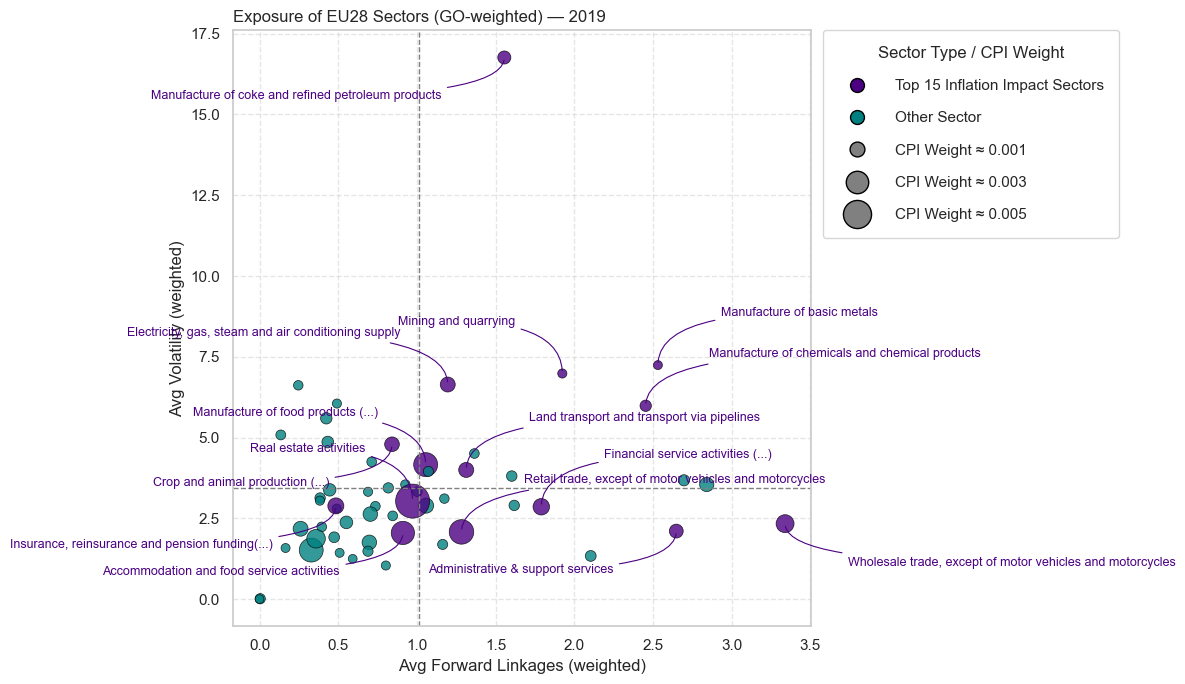

In [7]:
df_grouped = aggregate_sector_averages_eu28(2019, "eu28", weighting="output")


highlight = ["L68", "C19", "C10-C12", "D35", "A01", "K64", "G46", "G47", "K65", "H49", "I", "C20", "N", "C24", "B"]  # example
plot_scatter_by_sector_eu28_average_labeled(
    df_grouped, 2019, highlight, NACE_SHORT_DESCRIPTION_MAP,
    label_left_bottom=set(["K65","I","N", "C19", "A01"]),
    label_left_top=set(["L68", "C10-C12", "B", "D35"]),
    label_right_bottom=set(["G46","G46"]),
)



In [8]:
def plot_scatter_by_sector_regions_dynamic(year: int, region_map: dict[str, str], tag: str):
    """
    Plot sector-level scatter with one point per (sector, region subgroup), using dynamic CPI aggregation
    based on a provided region_map. Weights by gross output.

    Args:
        year (int): Year to visualize
        region_map (dict): Country-to-region mapping (e.g. IPSEN_REGION_MAP)
        tag (str): Label used in plot title (e.g. "ipsen", "north_south")
    """

    # Load volatility
    vol_df = pd.read_csv(SYSTEMIC_VOLATILITY_DIR / "II_PI_volatility.csv").rename(columns={"price_volatility": "Volatility"})
    vol_df = vol_df.set_index(["Country", "Sector"])

    # Load forward linkages
    A = pd.read_csv(SYSTEMIC_A_MATRIX_DIR / f"A_{year}.csv", header=[0, 1], index_col=[0, 1])
    A.columns.names = ["Country", "Sector"]
    forward_linkages = A.sum(axis=1).rename("ForwardLinkages")

    # Load gross output
    X = pd.read_csv(SYSTEMIC_X_VECTOR_DIR / f"X_{year}.csv", index_col=[0, 1])
    X = X.rename(columns={"gross_output": "GrossOutput"})

    # Load CPI weights (individual)
    cpi_path = SYSTEMIC_CPI_WEIGHTS_DIR / "individual" / f"cpi_weights_individual_{year}.csv"
    if not cpi_path.exists():
        print(f"Missing individual CPI weight file: {cpi_path}")
        return

    cpi = pd.read_csv(cpi_path, header=[0, 1], index_col=[0, 1])
    cpi.columns.names = ["Country", "Metric"]

    # Flatten CPI to single column using region_map
    data_rows = []
    for (country, sector), row in cpi.iterrows():
        region = region_map.get(country)
        if region is None:
            continue
        weight = row.get((country, "cpi_weight"), 0.0)
        data_rows.append({
            "Country": country,
            "Sector": sector,
            "Region": region,
            "CPIWeight": weight
        })

    cpi_df = pd.DataFrame(data_rows)
    cpi_df = cpi_df.set_index(["Country", "Sector"])

    # Join all datasets
    common_index = vol_df.index.intersection(forward_linkages.index).intersection(cpi_df.index).intersection(X.index)
    df = pd.concat([
        vol_df.loc[common_index],
        forward_linkages.loc[common_index],
        cpi_df.loc[common_index],
        X.loc[common_index]
    ], axis=1).reset_index()

    df["Weight"] = df["GrossOutput"]

    # Compute regional averages by sector
    def weighted_avg(g, col):
        w = g["Weight"]
        return (w * g[col]).sum() / w.sum() if w.sum() > 0 else 0.0

    df_grouped = df.groupby(["Sector", "Region"]).apply(lambda g: pd.Series({
        "Volatility": weighted_avg(g, "Volatility"),
        "ForwardLinkages": weighted_avg(g, "ForwardLinkages"),
        "CPIWeight": g["CPIWeight"].mean()
    })).reset_index()

    # Plot
    plt.figure(figsize=(10, 7))
    ax = sns.scatterplot(
        data=df_grouped,
        x="ForwardLinkages",
        y="Volatility",
        hue="Region",
        size="CPIWeight",
        palette="Set2",
        edgecolor="black",
        alpha=0.75,
        sizes=(20, 400),
        legend="brief"
    )

    for _, row in df_grouped.iterrows():
        if np.isfinite(row["ForwardLinkages"]) and np.isfinite(row["Volatility"]):
            ax.text(row["ForwardLinkages"], row["Volatility"], row["Sector"],
                    fontsize=7, ha="center", va="center")

    plt.axhline(df_grouped["Volatility"].mean(), color='grey', linestyle='--', linewidth=1)
    plt.axvline(df_grouped["ForwardLinkages"].mean(), color='grey', linestyle='--', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title(f"Regional Sector Exposure — {tag.upper()} {year} (Output-weighted, dynamic map)")
    plt.xlabel("Avg Forward Linkages")
    plt.ylabel("Avg Volatility")
    plt.tight_layout()
    plt.show()


C:\Users\danie\AppData\Local\Temp\ipykernel_22312\3677416294.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby(["Sector", "Region"]).apply(lambda g: pd.Series({


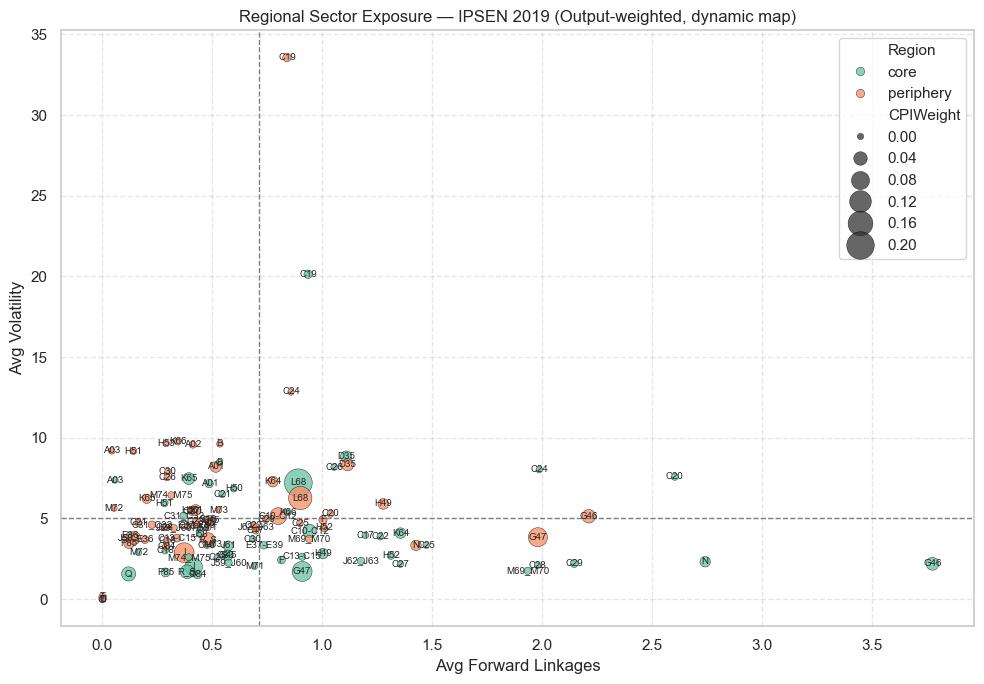

C:\Users\danie\AppData\Local\Temp\ipykernel_22312\3677416294.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby(["Sector", "Region"]).apply(lambda g: pd.Series({


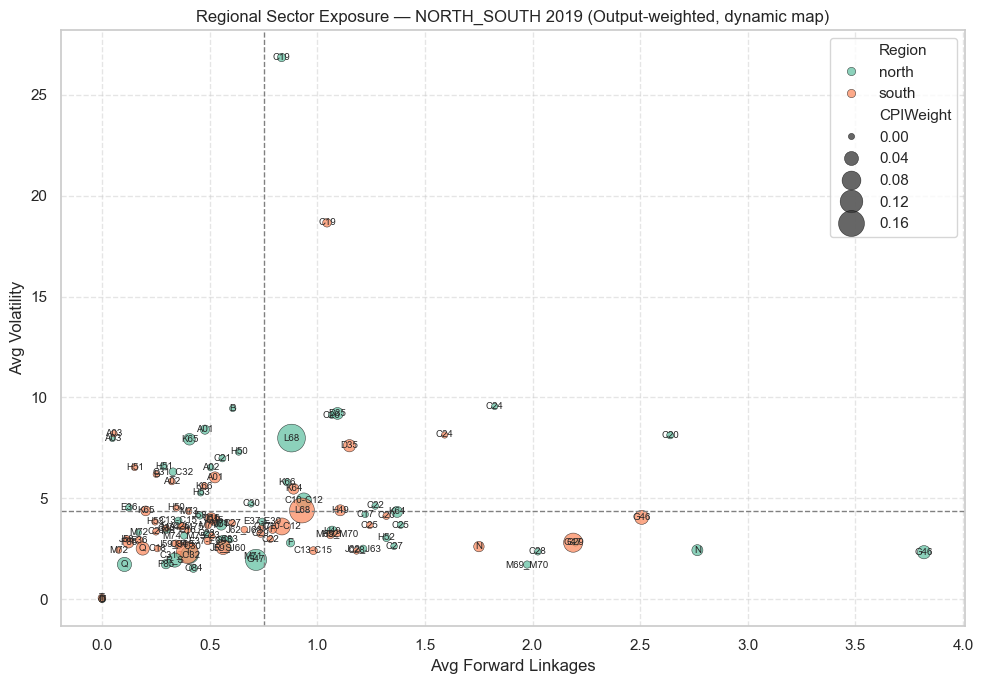

C:\Users\danie\AppData\Local\Temp\ipykernel_22312\3677416294.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby(["Sector", "Region"]).apply(lambda g: pd.Series({


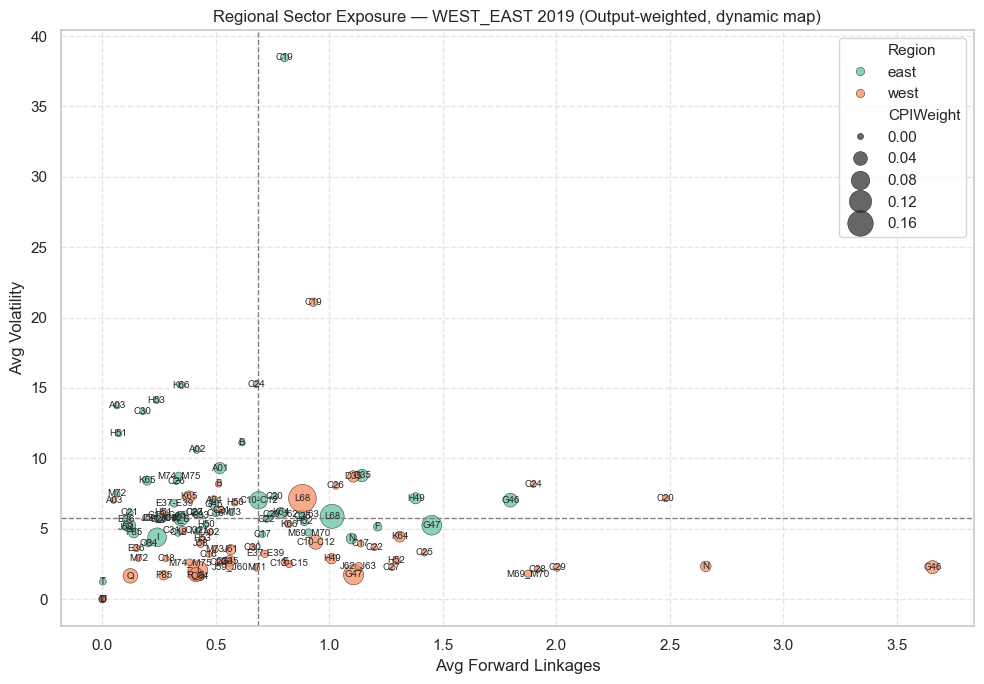

In [9]:
plot_scatter_by_sector_regions_dynamic(2019, IPSEN_REGION_MAP, tag="ipsen")
plot_scatter_by_sector_regions_dynamic(2019, EU_NORTH_SOUTH_MAP, tag="north_south")
plot_scatter_by_sector_regions_dynamic(2019, EU_WEST_EAST_MAP, tag="west_east")


In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_impact_table(df: pd.DataFrame, top_n: int = 10, subregion: str = None, output_path: Path = None):
    df = df.copy()

    # Normalize Region column once, before filtering
    if "Region" in df.columns:
        df["Region"] = df["Region"].astype(str).str.strip().str.lower()

    if subregion is not None:
        subregion = subregion.strip().lower()
        print(f"Filtering for subregion: '{subregion}'")
        print("Available Region values BEFORE filter:", sorted(df["Region"].dropna().unique()))
        df = df[df["Region"] == subregion]

    if df.empty:
        print(f"No data for Region subgroup '{subregion}' — skipping plot.")
        return

    df["Total Impact"] = df["Direct Impact"] + df["Indirect Impact"]

    # Replace sector codes with short description if mapping exists
    df["Sector Label"] = df["Sector"].apply(lambda x: NACE_SHORT_DESCRIPTION_MAP.get(x, x))
    df["Label"] = df["Country"] + " — " + df["Sector Label"]

    # Select top contributors
    top = df.nlargest(top_n, "Total Impact").sort_values("Total Impact", ascending=False)

    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax2 = ax1.twiny()

    ax1.barh(top["Label"], top["Direct Impact"], color="tab:blue", label="Direct Effect")
    ax1.barh(top["Label"], top["Indirect Impact"], left=top["Direct Impact"], color="tab:orange", label="Indirect Effect")

    # Plot price shock as cyan dots
    ax2.scatter(top["Price Shock"], top["Label"], color="darkred", zorder=5, label="Price Shock")

    # Add custom legend entry for scatter
    handles, labels = ax1.get_legend_handles_labels()
    scatter_legend = Line2D([0], [0], marker='o', color='w', label='Price Shock',
                            markerfacecolor='red', markersize=8)
    handles.append(scatter_legend)
    labels.append("Price Shock")
    ax1.legend(handles=handles, labels=labels, loc="lower right")

    # Title and axes
    region_label = df["Region"].iloc[0].capitalize()
    year_label = df["Year"].iloc[0]
    ax1.set_title(f"Top {top_n} Inflation Contributors — {region_label}, {year_label}", loc="left", fontsize = 16, fontweight="bold")  
    ax1.set_xlabel("CPI Inflation Impact (%)")
    ax2.set_xlabel("Price Shock (%)")
    ax1.invert_yaxis()
    ax1.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    if output_path:
        filename = output_path / f"impact_bar_{region_label}_{year_label}.png"
        plt.savefig(filename)
        print(f"Saved: {filename}")
        plt.close()
    else:
        plt.show()


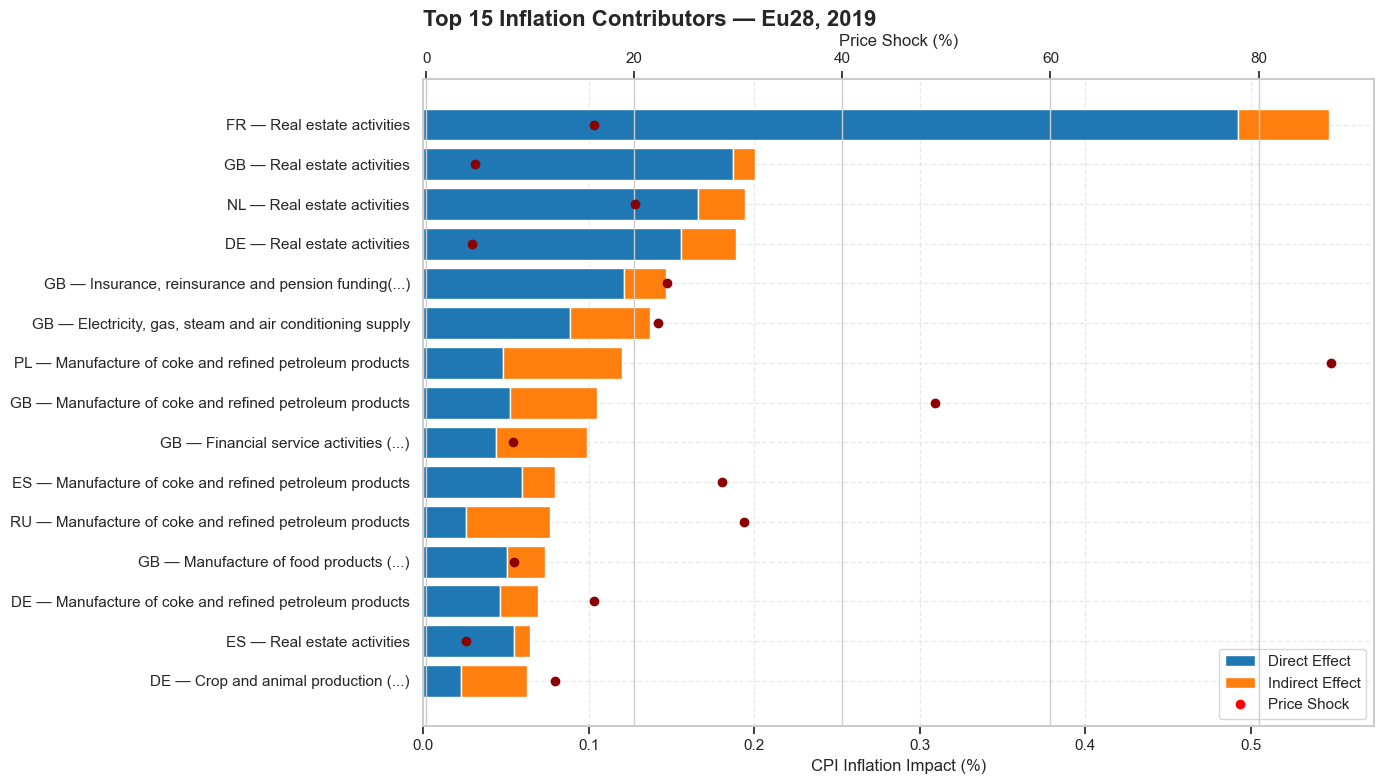

In [11]:
df = load_weighted_impact("eu28", 2019, SYSTEMIC_WEIGHTED_IMPACTS_DIR, SYSTEMIC_VOLATILITY_DIR/"II_PI_volatility.csv")
plot_impact_table(df, top_n=15)


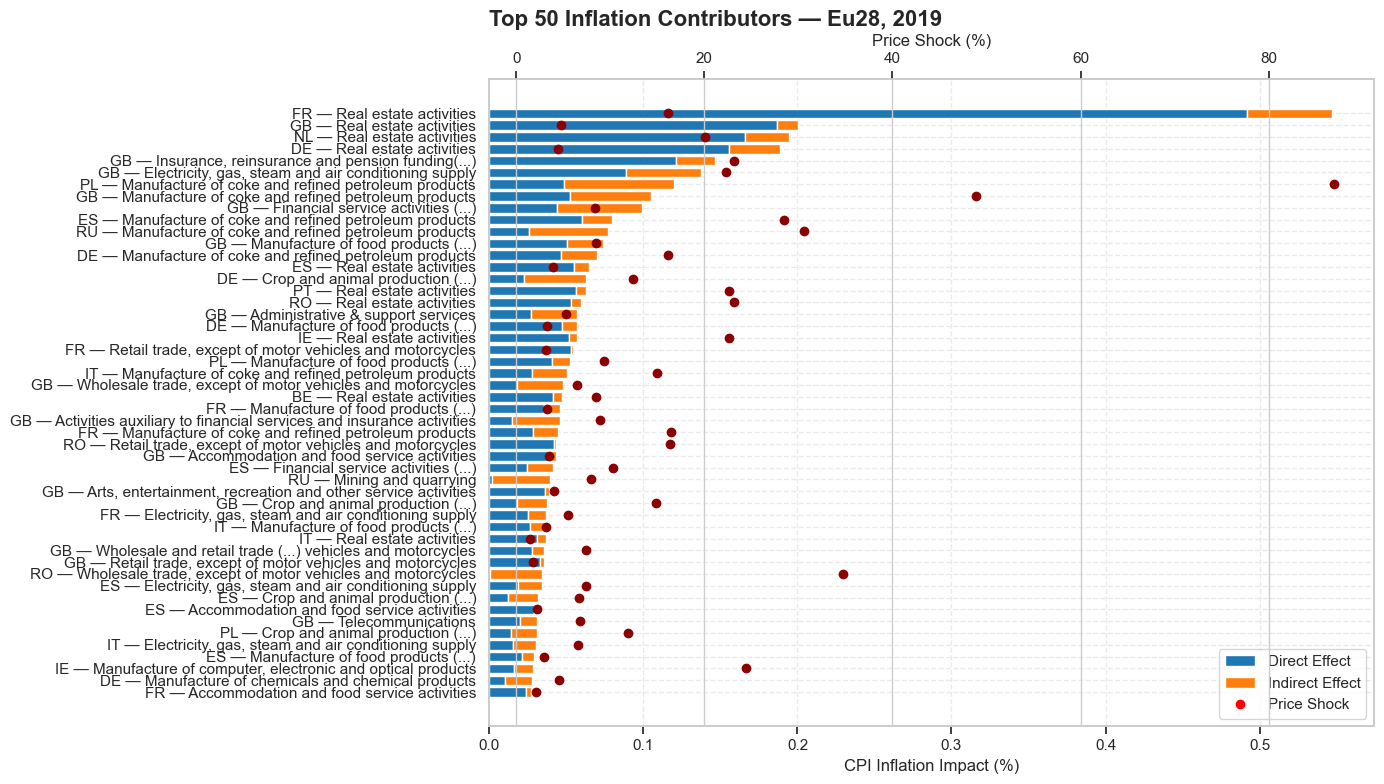

In [12]:
df = load_weighted_impact("eu28", 2019, SYSTEMIC_WEIGHTED_IMPACTS_DIR, SYSTEMIC_VOLATILITY_DIR/"II_PI_volatility.csv")
plot_impact_table(df, top_n=50)


In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_sector_impact_eu28_avg(df: pd.DataFrame, top_n: int = 15, output_path: Path = None):
    """
    Plots the average inflation impact per sector using EU28 CPI weighting.

    Args:
        df (pd.DataFrame): Contains columns ['Sector', 'Direct Impact', 'Indirect Impact', 'Price Shock', 'Year'].
        top_n (int): Number of top sectors to show.
        output_path (Path, optional): Path to save the figure.
    """
    df = df.copy()

    # Compute total impact
    df["Total Impact"] = df["Direct Impact"] + df["Indirect Impact"]

    # Aggregate sector-level averages (already CPI-weighted across countries)
    sector_avg = df.groupby("Sector").agg({
        "Direct Impact": "mean",
        "Indirect Impact": "mean",
        "Total Impact": "mean",
        "Price Shock": "mean",
        "Year": "first"
    }).reset_index()

    # Replace sector code with description if mapping exists
    sector_avg["Sector Label"] = sector_avg["Sector"].map(NACE_SHORT_DESCRIPTION_MAP).fillna(sector_avg["Sector"])

    # Sort and select top N
    top = sector_avg.nlargest(top_n, "Total Impact").sort_values("Total Impact", ascending=False)

    # Plot
    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax2 = ax1.twiny()

    ax1.barh(top["Sector Label"], top["Direct Impact"], color="tab:blue", label="Direct Effect")
    ax1.barh(top["Sector Label"], top["Indirect Impact"], left=top["Direct Impact"], color="tab:orange", label="Indirect Effect")
    ax2.scatter(top["Price Shock"], top["Sector Label"], color="darkred", zorder=5)

    # Add price shock dot to legend
    handles, labels = ax1.get_legend_handles_labels()
    scatter_legend = Line2D([0], [0], marker='o', color='w', label='Price Shock',
                            markerfacecolor='red', markersize=8)
    handles.append(scatter_legend)
    labels.append("Price Shock")
    ax1.legend(handles=handles, labels=labels, loc="lower right")

    # Labels and title
    year_label = int(top["Year"].iloc[0])
    ax1.set_title(f"Top {top_n} Average Sector Impacts (EU28 CPI) — {year_label}", loc="left", fontsize = 16, fontweight="bold")
    ax1.set_xlabel("CPI Inflation Impact (%)")
    ax2.set_xlabel("Price Change (%)")
    ax1.invert_yaxis()
    ax1.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    if output_path:
        filename = output_path / f"impact_bar_avg_eu28_{year_label}.png"
        plt.savefig(filename)
        print(f"Saved: {filename}")
        plt.close()
    else:
        plt.show()


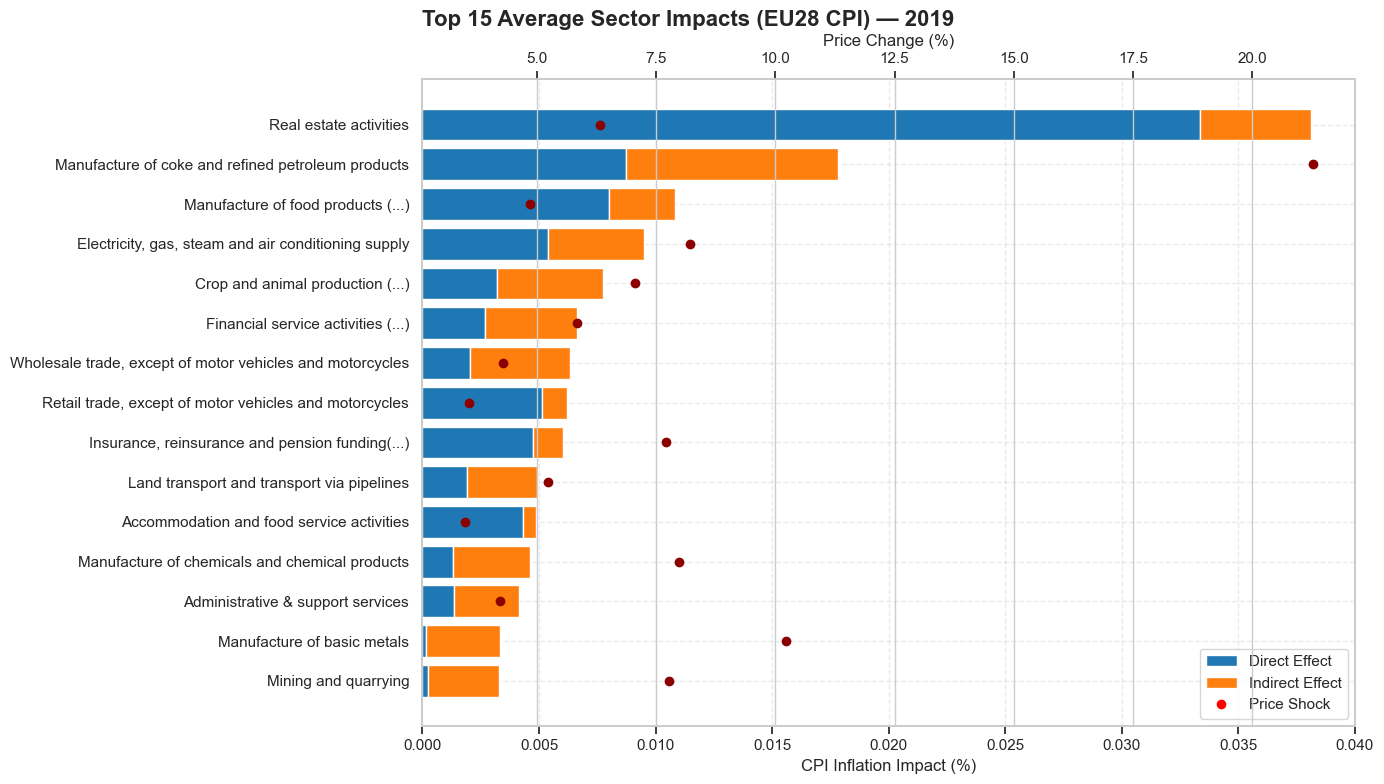

In [13]:
df = load_weighted_impact("eu28", 2019, SYSTEMIC_WEIGHTED_IMPACTS_DIR, SYSTEMIC_VOLATILITY_DIR / "II_PI_volatility.csv")
plot_sector_impact_eu28_avg(df, top_n=15)


Filtering for subregion: 'periphery'
Available Region values BEFORE filter: ['core', 'periphery']


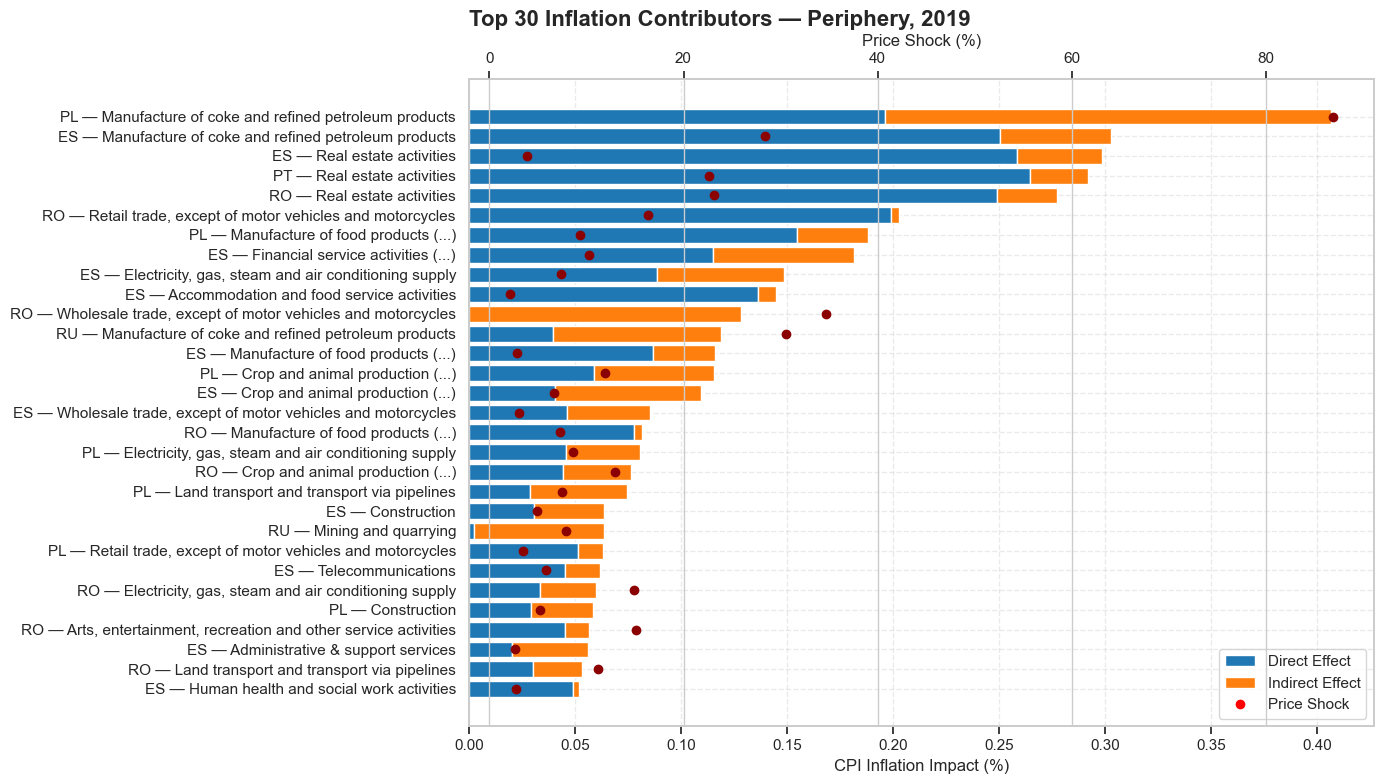

In [14]:
df = load_weighted_impact("ipsen", 2019, SYSTEMIC_WEIGHTED_IMPACTS_DIR, SYSTEMIC_VOLATILITY_DIR/"II_PI_volatility.csv")
plot_impact_table(df, top_n=30, subregion="periphery")


In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_sector_impact_eu28_avg_eu28(df: pd.DataFrame, top_n: int = 15, output_path: Path = None):
    """
    Plots the average inflation impact per sector using EU28 CPI weighting (restricted to EU28 countries).

    Args:
        df (pd.DataFrame): Contains ['Country', 'Sector', 'Direct Impact', 'Indirect Impact', 'Price Shock', 'Year'].
        top_n (int): Number of top sectors to show.
        output_path (Path, optional): Path to save the figure.
    """
    df = df.copy()

    # Define EU28 country codes
    EU28 = {
        "AT", "BE", "BG", "HR", "CY", "CZ", "DK", "EE", "FI", "FR",
        "DE", "GR", "HU", "IE", "IT", "LV", "LT", "LU", "MT", "NL",
        "PL", "PT", "RO", "SK", "SI", "ES", "SE", "GB"
    }

    # Filter to EU28 countries only
    df = df[df["Country"].isin(EU28)]

    # Compute total impact
    df["Total Impact"] = df["Direct Impact"] + df["Indirect Impact"]

    # Aggregate sector-level averages
    sector_avg = df.groupby("Sector").agg({
        "Direct Impact": "mean",
        "Indirect Impact": "mean",
        "Total Impact": "mean",
        "Price Shock": "mean",
        "Year": "first"
    }).reset_index()

    # Replace sector code with description
    sector_avg["Sector Label"] = sector_avg["Sector"].map(NACE_SHORT_DESCRIPTION_MAP).fillna(sector_avg["Sector"])

    # Sort and select top N
    top = sector_avg.nlargest(top_n, "Total Impact").sort_values("Total Impact", ascending=False)

    # Plot
    fig, ax1 = plt.subplots(figsize=(14, 8))
    ax2 = ax1.twiny()

    ax1.barh(top["Sector Label"], top["Direct Impact"], color="#1f77b4", label="Direct Effect")
    ax1.barh(top["Sector Label"], top["Indirect Impact"], left=top["Direct Impact"], color="#ff7f0e", label="Indirect Effect")
    ax2.scatter(top["Price Shock"], top["Sector Label"], color="#8B0000", zorder=5)

    # Add price shock dot to legend
    handles, labels = ax1.get_legend_handles_labels()
    scatter_legend = Line2D([0], [0], marker='o', color='w', label='Price Shock',
                            markerfacecolor='#8B0000', markersize=8)
    handles.append(scatter_legend)
    labels.append("Price Shock")
    ax1.legend(handles=handles, labels=labels, loc="lower right")

    # Labels and title
    year_label = int(top["Year"].iloc[0])
    ax1.set_title(f"Top {top_n} Average Sector Impacts (EU28 CPI, EU28 Countries Only) — {year_label}",
                  loc="left", fontsize=16, fontweight="bold")
    ax1.set_xlabel("CPI Inflation Impact (%)")
    ax2.set_xlabel("Price Change (%)")
    ax1.invert_yaxis()
    ax1.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    if output_path:
        filename = output_path / f"impact_bar_avg_eu28_{year_label}.png"
        plt.savefig(filename)
        print(f"Saved: {filename}")
        plt.close()
    else:
        plt.show()


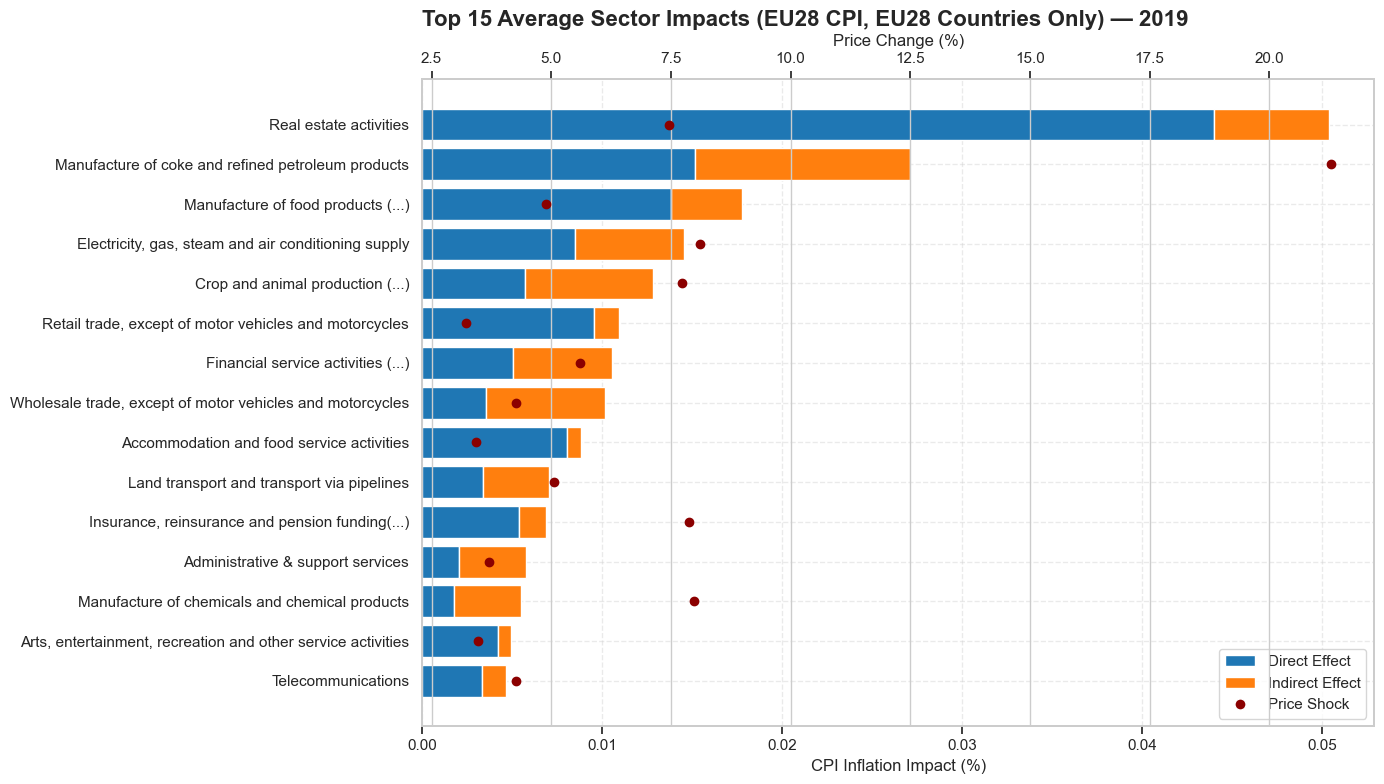

In [16]:
df = load_weighted_impact("ipsen", 2019, SYSTEMIC_WEIGHTED_IMPACTS_DIR, SYSTEMIC_VOLATILITY_DIR/"II_PI_volatility.csv")
plot_sector_impact_eu28_avg_eu28(df, top_n=15)


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sector_impact_eu28_boxplot(df: pd.DataFrame, top_n: int = 15, output_path: Path = None):
    """
    Horizontal boxplot of sector inflation impacts across countries for top N sectors based on mean impact.

    Args:
        df (pd.DataFrame): Must contain ['Sector', 'Direct Impact', 'Indirect Impact', 'Country', 'Year'].
        top_n (int): Number of top sectors to show (based on average total impact).
        output_path (Path, optional): If set, saves the figure to this path.
    """
    df = df.copy()
    df["Total Impact"] = df["Direct Impact"] + df["Indirect Impact"]

    # Compute average per sector
    sector_avg = df.groupby("Sector")["Total Impact"].mean().nlargest(top_n)
    top_sectors = sector_avg.index

    # Filter data
    df_top = df[df["Sector"].isin(top_sectors)].copy()
    df_top["Sector Label"] = df_top["Sector"].map(NACE_SHORT_DESCRIPTION_MAP).fillna(df_top["Sector"])

    # Keep consistent order
    order = df_top.groupby("Sector Label")["Total Impact"].mean().sort_values(ascending=False).index

    # Plot
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df_top, y="Sector Label", x="Total Impact", order=order, color="lightblue")
    plt.grid(True, axis='x', linestyle="--", alpha=0.4)
    plt.title("Top {} Sectoral Inflation Impact Distributions (EU28 CPI)".format(top_n), fontsize=16, fontweight="bold")
    plt.xlabel("CPI Inflation Impact (%)")
    plt.ylabel("")

    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved: {output_path}")
        plt.close()
    else:
        plt.show()


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sector_impact_eu28_boxplot_clipped(df: pd.DataFrame, top_n: int = 15, output_path: Path = None):
    """
    Horizontal boxplot for sectoral inflation impacts across countries.
    Excludes extreme axis range distortion while keeping boxplot robust.

    Args:
        df (pd.DataFrame): Contains ['Sector', 'Direct Impact', 'Indirect Impact', 'Country', 'Year'].
        top_n (int): Top sectors to show based on mean impact.
        output_path (Path, optional): Save plot if path provided.
    """
    df = df.copy()
    df["Total Impact"] = df["Direct Impact"] + df["Indirect Impact"]

    # Top sectors by average impact
    top_sectors = (
        df.groupby("Sector")["Total Impact"]
        .mean()
        .nlargest(top_n)
        .index
    )

    df_top = df[df["Sector"].isin(top_sectors)].copy()
    df_top["Sector Label"] = df_top["Sector"].map(NACE_SHORT_DESCRIPTION_MAP).fillna(df_top["Sector"])
    
    order = (
        df_top.groupby("Sector Label")["Total Impact"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # Plot
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        data=df_top,
        y="Sector Label",
        x="Total Impact",
        order=order,
        color="skyblue",
        width=0.5,
        showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "red", "markersize": 8, "markeredgecolor": "black"},
    )

    # Clip x-axis to avoid right tail distortion
    xmax = df_top["Total Impact"].quantile(0.96)
    plt.xlim(0, xmax)

    plt.grid(True, axis='x', linestyle="--", alpha=0.5)
    plt.title(f"Top {top_n} Sectoral Inflation Impact Distributions (EU28 CPI)", fontsize=16, fontweight="bold")
    plt.xlabel("CPI Inflation Impact (%)")
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved: {output_path}")
        plt.close()
    else:
        plt.show()


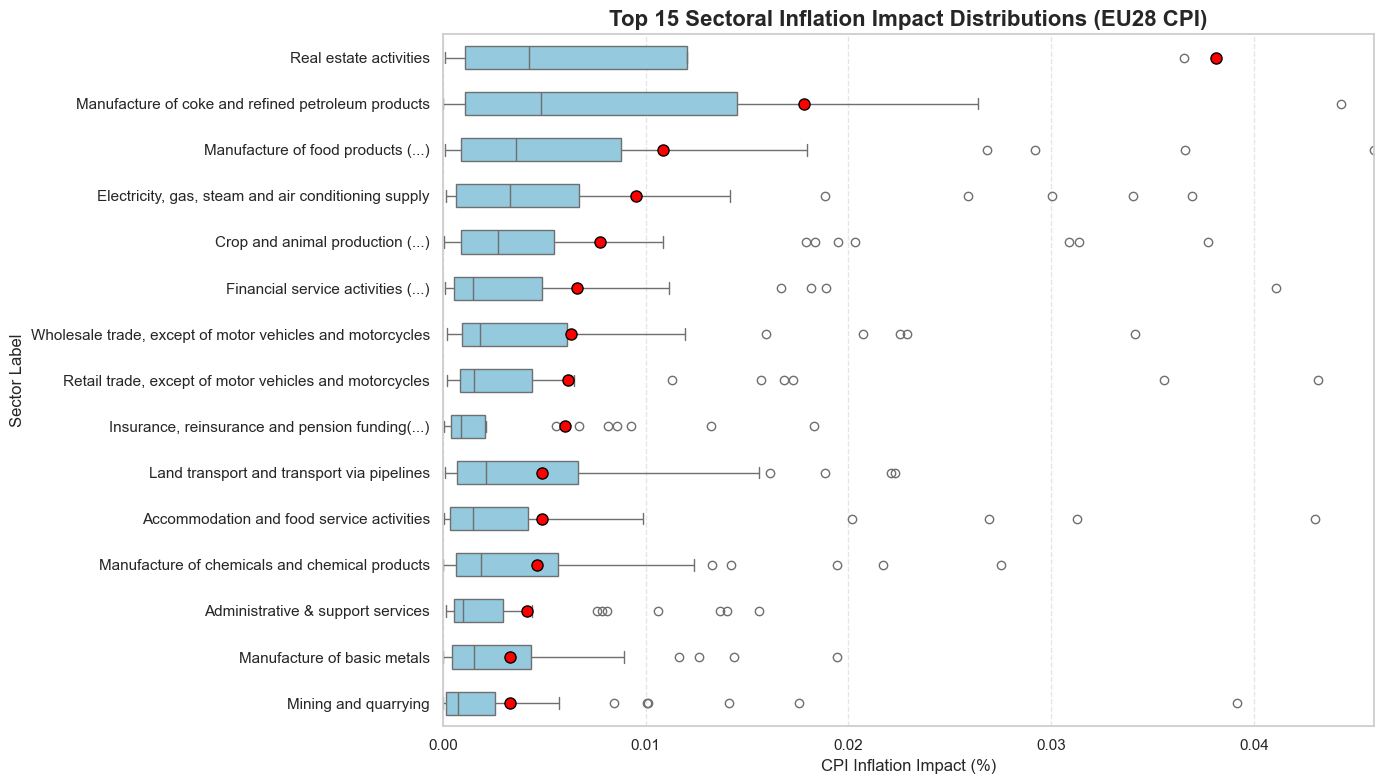

In [19]:
df_path = SYSTEMIC_WEIGHTED_IMPACTS_DIR / "weighted_impacts_eu28_2019.csv"
df = pd.read_csv(df_path)
plot_sector_impact_eu28_boxplot_clipped(df, top_n=15)


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sector_impact_eu28_boxplot_clipped_eu28(df: pd.DataFrame, top_n: int = 15, output_path: Path = None):
    """
    Horizontal boxplot for sectoral inflation impacts across countries.
    Excludes extreme axis range distortion while keeping boxplot robust.

    Args:
        df (pd.DataFrame): Contains ['Sector', 'Direct Impact', 'Indirect Impact', 'Country', 'Year'].
        top_n (int): Top sectors to show based on mean impact.
        output_path (Path, optional): Save plot if path provided.
    """
    df = df.copy()
    df["Total Impact"] = df["Direct Impact"] + df["Indirect Impact"]

    # Define EU28 country codes
    EU28 = {
        "AT", "BE", "BG", "HR", "CY", "CZ", "DK", "EE", "FI", "FR",
        "DE", "GR", "HU", "IE", "IT", "LV", "LT", "LU", "MT", "NL",
        "PL", "PT", "RO", "SK", "SI", "ES", "SE", "GB"
    }

    # Filter to EU28 countries only
    df = df[df["Country"].isin(EU28)]

    # Top sectors by average impact
    top_sectors = (
        df.groupby("Sector")["Total Impact"]
        .mean()
        .nlargest(top_n)
        .index
    )

    df_top = df[df["Sector"].isin(top_sectors)].copy()
    df_top["Sector Label"] = df_top["Sector"].map(NACE_SHORT_DESCRIPTION_MAP).fillna(df_top["Sector"])
    
    order = (
        df_top.groupby("Sector Label")["Total Impact"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # Plot
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        data=df_top,
        y="Sector Label",
        x="Total Impact",
        order=order,
        color="skyblue",
        width=0.5,
        showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "red", "markersize": 8, "markeredgecolor": "black"},
    )

    # Clip x-axis to avoid right tail distortion
    xmax = df_top["Total Impact"].quantile(0.98)
    plt.xlim(0, xmax)

    plt.grid(True, axis='x', linestyle="--", alpha=0.5)
    plt.title(f"Top {top_n} Sectoral Inflation Impact Distributions (EU28 CPI, EU28 origin)", fontsize=16, fontweight="bold")
    plt.xlabel("CPI Inflation Impact (%)")
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved: {output_path}")
        plt.close()
    else:
        plt.show()

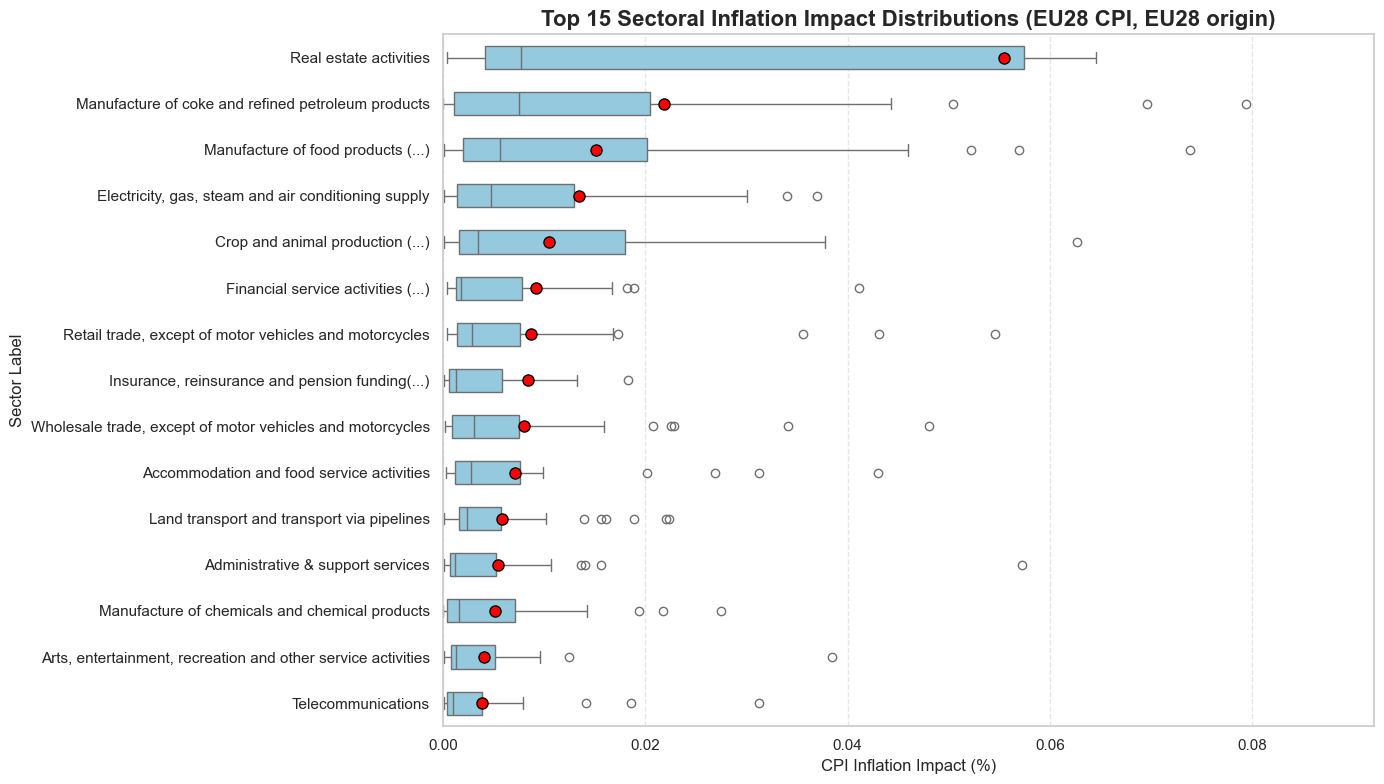

In [21]:
df_path = SYSTEMIC_WEIGHTED_IMPACTS_DIR / "weighted_impacts_eu28_2019.csv"
df = pd.read_csv(df_path)
plot_sector_impact_eu28_boxplot_clipped_eu28(df, top_n=15)

In [22]:
from matplotlib.colors import LogNorm

def plot_country_sector_heatmap(
    df: pd.DataFrame,
    subregion: str = None,
    europe_only: bool = True,
    log_scale: bool = True,
    row_sort_by: str = "impact",
    col_sort_by: str = "impact",
    output_path: Path = None,
    year: int = None
):
    df = df.copy()

    if "Region" in df.columns:
        df["Region"] = df["Region"].astype(str).str.strip().str.lower()
    if subregion:
        subregion = subregion.strip().lower()
        df = df[df["Region"] == subregion]

    if year is not None:
        year = int(year)

    EU28 = {
        "AT", "BE", "BG", "HR", "CY", "CZ", "DK", "GR", "FI", "FR",
        "DE", "EE", "HU", "IE", "IT", "LV", "LT", "LU", "MT", "NL",
        "PL", "PT", "RO", "SK", "SI", "ES", "SE", "GB"
    }
    if europe_only:
        df = df[df["Country"].isin(EU28)]

    if df.empty:
        print(f"No data to plot for region '{subregion}' and EU-only = {europe_only}")
        return

    pivot = df.pivot_table(
        index="Sector",
        columns="Country",
        values="Total Impact",
        aggfunc="sum",
        fill_value=0
    )

    # Sort rows (sectors)
    if row_sort_by == "impact":
        pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
    elif row_sort_by == "volatility":
        row_vol = df.groupby("Sector")["Price Shock"].mean()
        row_vol = row_vol.reindex(pivot.index).dropna()
        pivot = pivot.loc[row_vol.sort_values(ascending=False).index]

    # Sort columns (countries)
    if col_sort_by == "impact":
        pivot = pivot.loc[:, pivot.sum(axis=0).sort_values(ascending=False).index]
    elif col_sort_by == "volatility":
        col_vol = df.groupby("Country")["Price Shock"].mean()
        col_vol = col_vol.reindex(pivot.columns).dropna()
        pivot = pivot.loc[:, col_vol.sort_values(ascending=False).index]


    # Replace sector codes in heatmap columns
    pivot.index = [NACE_SHORT_DESCRIPTION_MAP.get(code, code) for code in pivot.index]

    plt.figure(figsize=(16, max(8, 0.3 * pivot.shape[0])))  # 0.3" per sector
    if log_scale:
        sns.heatmap(
            pivot + 1e-6,
            cmap="YlOrBr",
            linewidths=0.3,
            linecolor="gray",
            norm=LogNorm(vmin=1e-6, vmax=pivot.values.max()),
            cbar_kws={"label": "Total Impact (log scale)"}
        )
    else:
        sns.heatmap(
            pivot,
            cmap="YlOrBr",
            linewidths=0.3,
            linecolor="gray",
            cbar_kws={"label": "Total Impact"}
        )

        plt.yticks(ticks=np.arange(len(pivot.index)) + 0.5, labels=pivot.index, rotation=0, fontsize=8)

    title = f"Inflation Impact Heatmap of EU28 Sectors ({year})" if year else "Inflation Impact Heatmap of EU28 Sectors"
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel("Country")
    plt.ylabel("Sector")
    plt.tight_layout()

    if output_path:
        filename = output_path / f"heatmap_{subregion if subregion else 'all'}_eu28.png"
        plt.savefig(filename)
        print(f"Saved: {filename}")
        plt.close()
    else:
        plt.show()


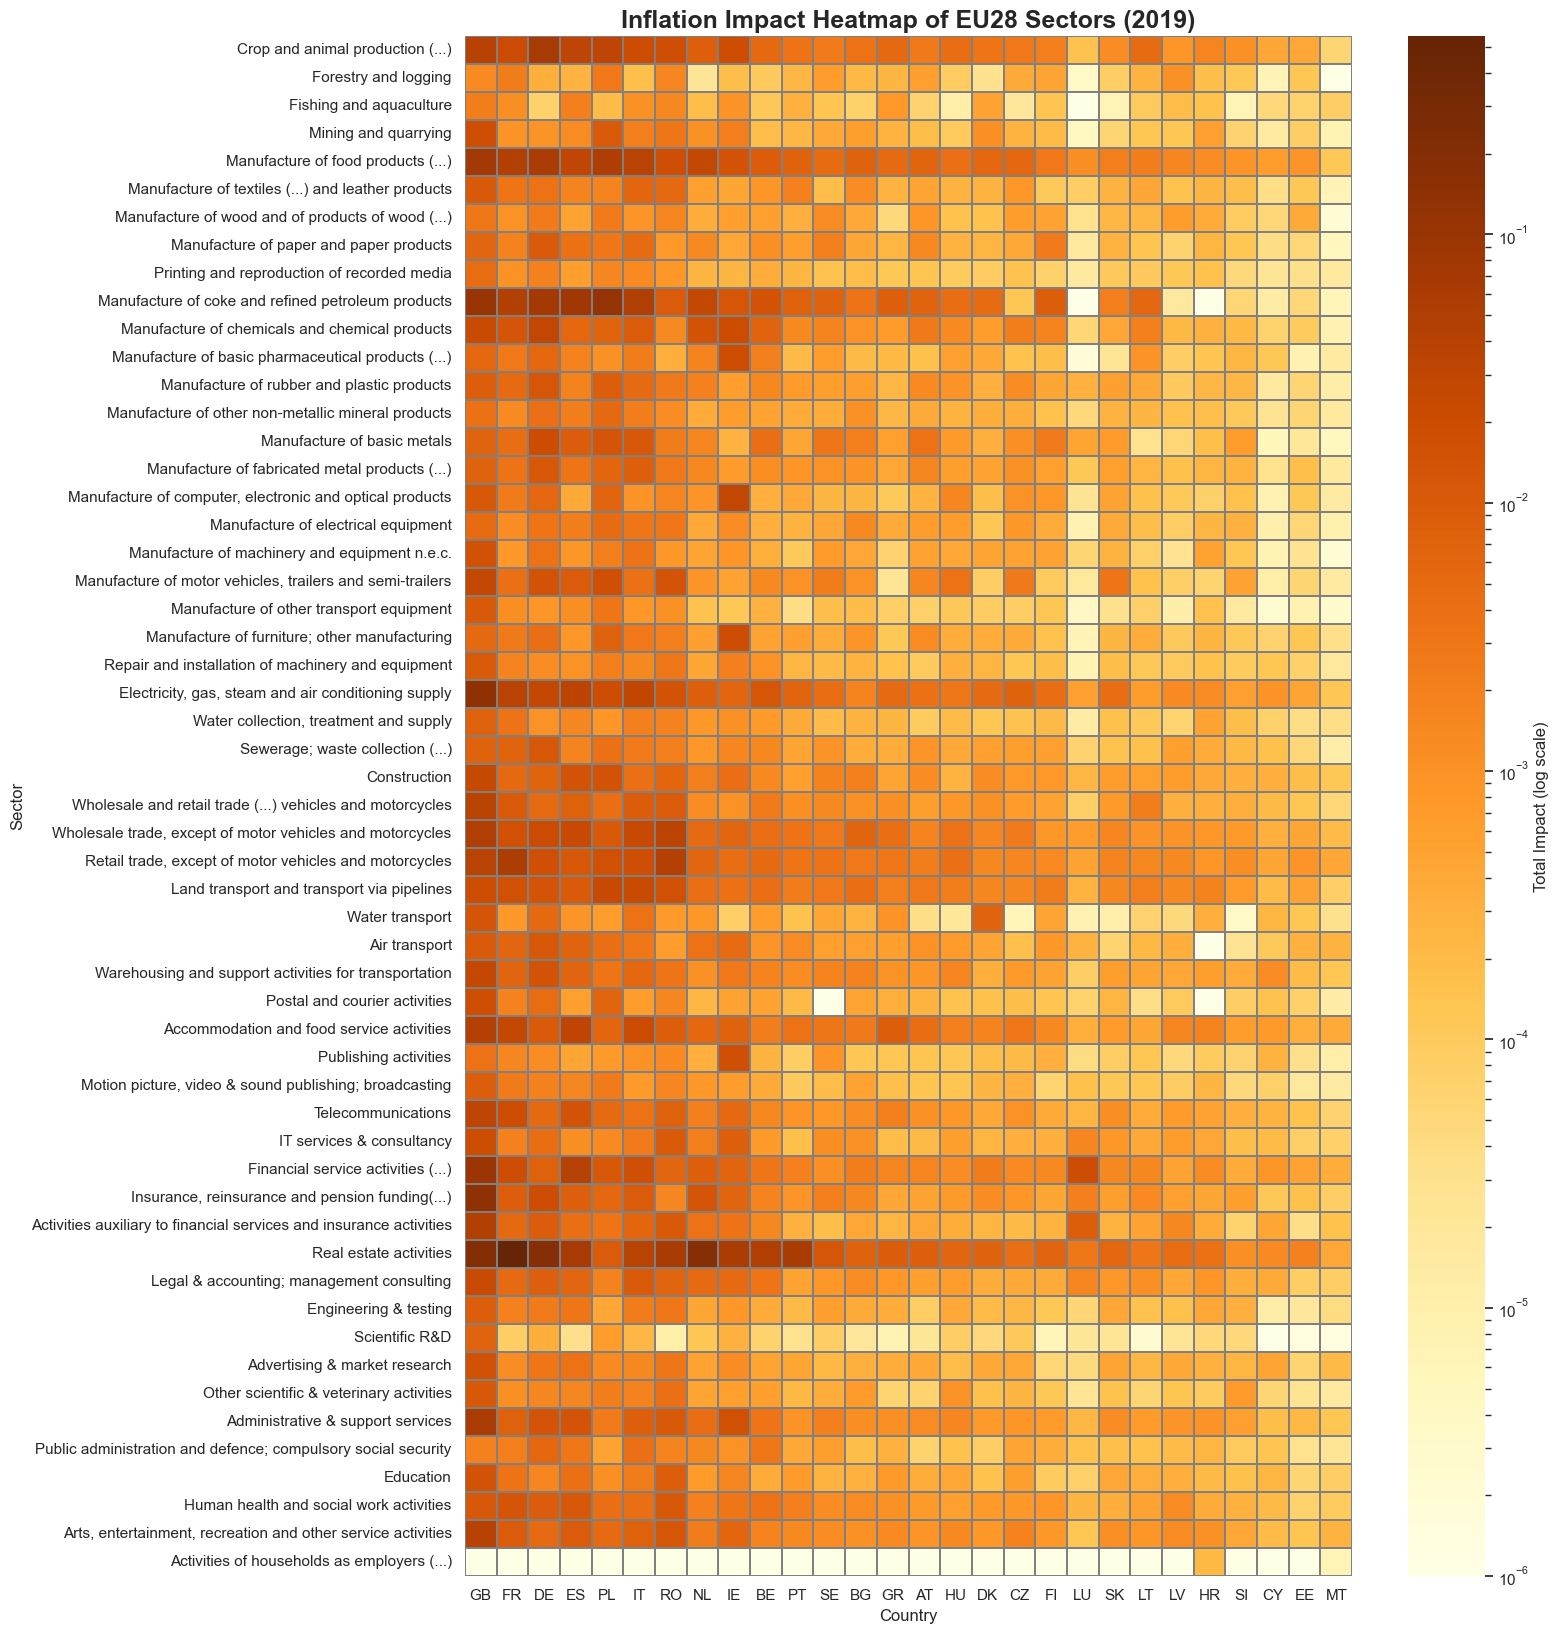

In [23]:
# Average Price Shock by Country and Sector

df = load_weighted_impact("eu28", 2019, SYSTEMIC_WEIGHTED_IMPACTS_DIR, SYSTEMIC_VOLATILITY_DIR/"II_PI_volatility.csv")
plot_country_sector_heatmap(df, subregion="eu28", log_scale=True, row_sort_by=None, col_sort_by="impact", year=2019)

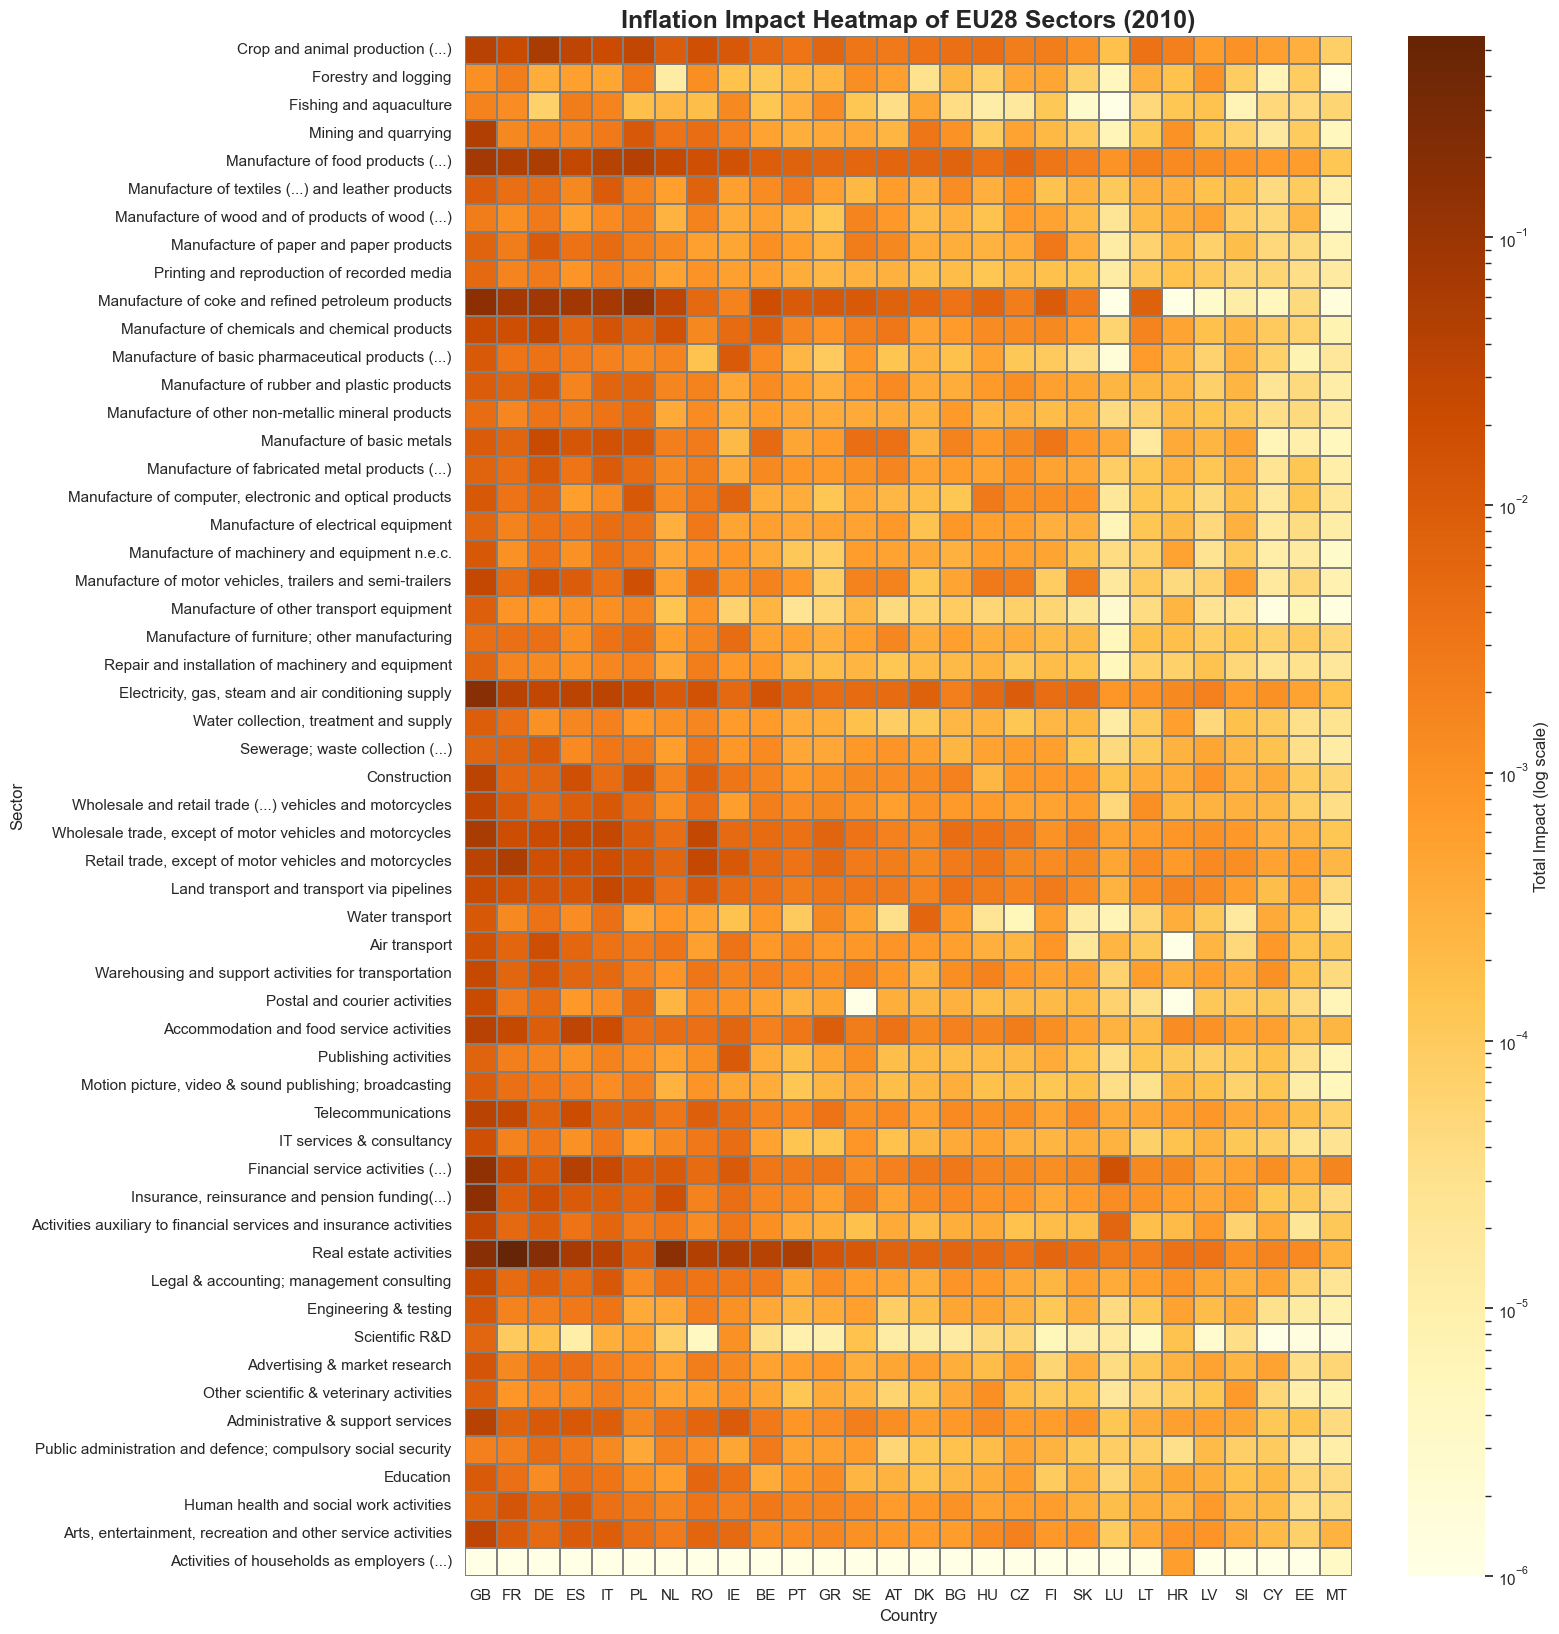

In [24]:
# Average Price Shock by Country and Sector

df = load_weighted_impact("eu28", 2010, SYSTEMIC_WEIGHTED_IMPACTS_DIR, SYSTEMIC_VOLATILITY_DIR/"II_PI_volatility.csv")
plot_country_sector_heatmap(df, subregion="eu28", log_scale=True, row_sort_by=None, col_sort_by="impact", year=2010)

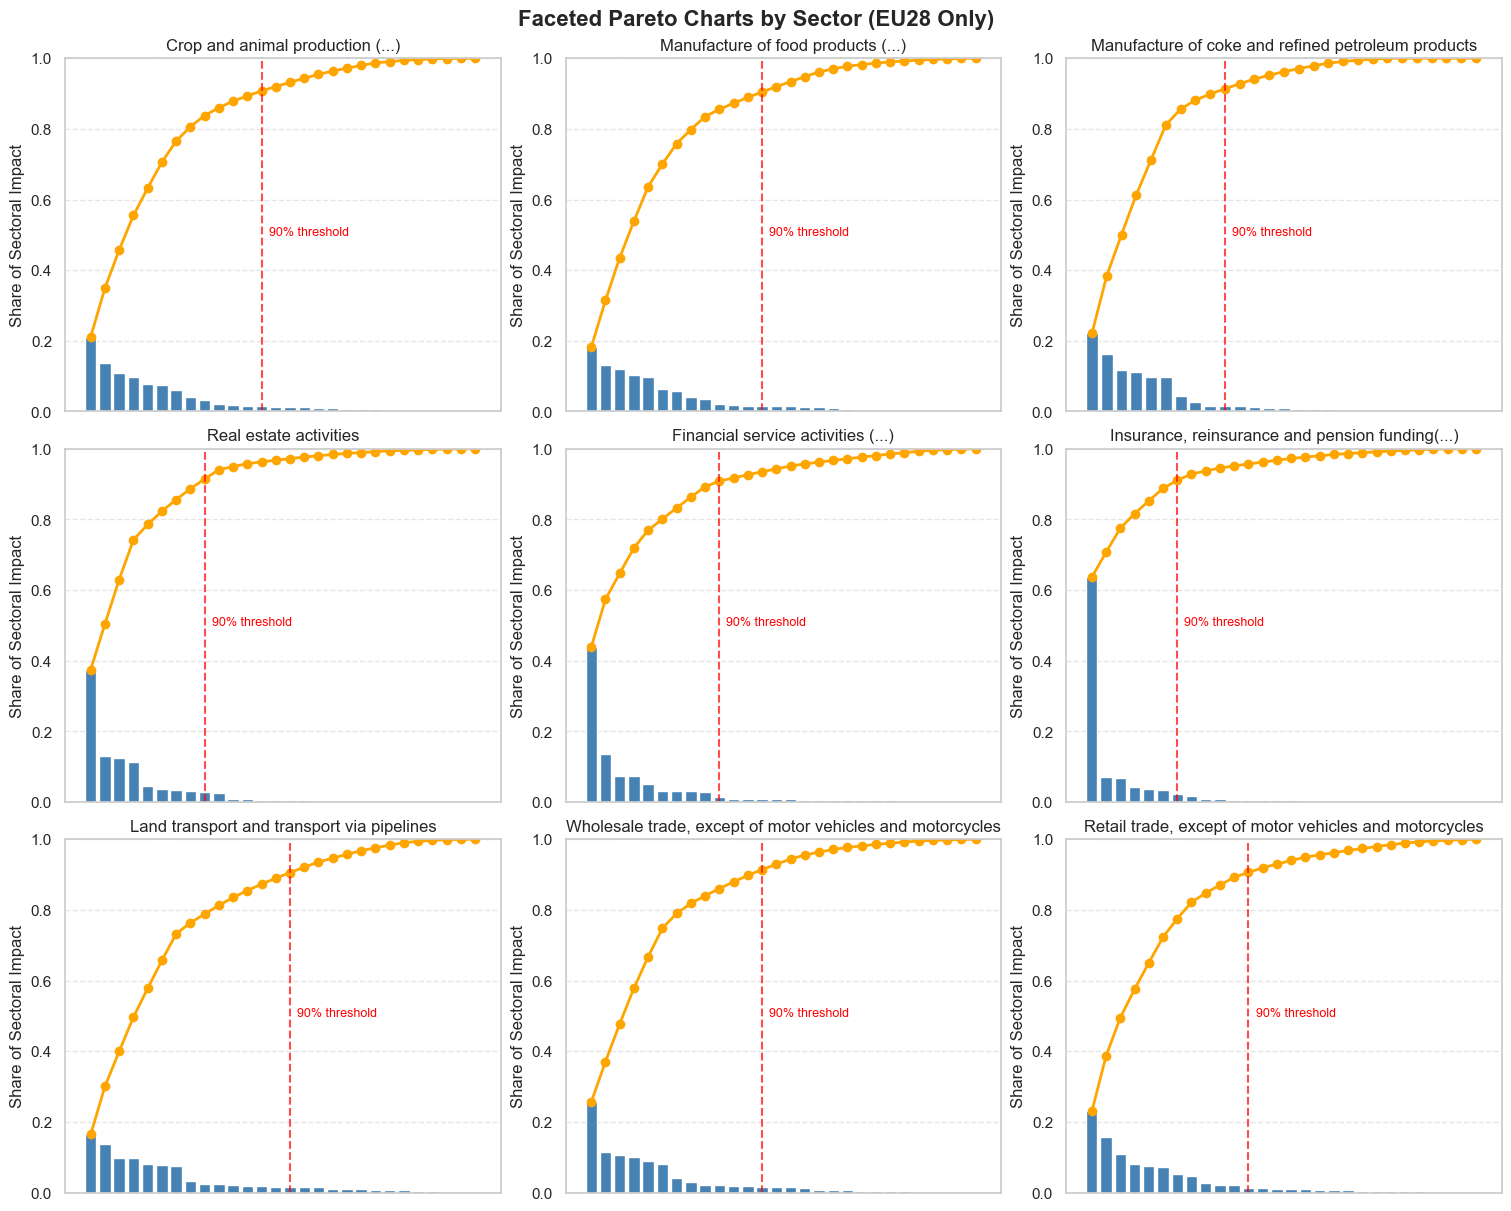

In [25]:

def plot_faceted_pareto_eu28(df: pd.DataFrame, sectors: list, ncols: int = 3):
    """
    Create a grid of Pareto charts (bars + cumulative lines) — one per sector, EU28 countries only.

    Args:
        df (pd.DataFrame): Data with columns ['Sector', 'Country', 'Total Impact'].
        sectors (list): Sector codes to include.
        ncols (int): Number of subplot columns.
    """
    # Define EU28 country codes
    EU28 = {
        "AT", "BE", "BG", "HR", "CY", "CZ", "DK", "EE", "FI", "FR",
        "DE", "GR", "HU", "IE", "IT", "LV", "LT", "LU", "MT", "NL",
        "PL", "PT", "RO", "SK", "SI", "ES", "SE", "GB"
    }

    # Filter to EU28 countries only
    df = df[df["Country"].isin(EU28)]

    n = len(sectors)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), constrained_layout=True)
    axes = axes.flatten()

    for i, sector in enumerate(sectors):
        ax = axes[i]
        data = (
            df[df["Sector"] == sector]
            .groupby("Country")["Total Impact"]
            .sum()
            .sort_values(ascending=False)
        )

        # Normalize
        share = data / data.sum()
        cumsum = share.cumsum()

        # Identify position where 90% of cumulative impact is reached
        threshold_index = np.argmax(cumsum.values >= 0.9)
        threshold_country = data.index[threshold_index]

        ax.bar(data.index, share.values, color="steelblue")
        ax.plot(data.index, cumsum.values, color="orange", marker="o", linewidth=2)

        ax.grid(True, axis='y', linestyle='--', alpha=0.5)
        ax.set_ylim(0, 1)
        ax.set_title(NACE_SHORT_DESCRIPTION_MAP.get(sector, sector))
        ax.set_xticks([])
        ax.set_ylabel("Share of Sectoral Impact")
        ax.axvline(x=threshold_index, color="red", linestyle="--", alpha=0.7)
        ax.text(threshold_index + 0.5 , 0.5, "90% threshold", color="red", fontsize=9)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Faceted Pareto Charts by Sector (EU28 Only)", fontsize=16, fontweight="bold")
    plt.show()

plot_faceted_pareto_eu28(df, sectors=["A01", "C10-C12", "C19", "L68", "K64", "K65", "H49", "G46", "G47"], ncols=3)

In [26]:
def plot_sector_impact_over_time(
    sector_code: str = None,
    tag: str = "eu28",
    exclude_countries: list[str] = None,
    exclude_sector: str = None,
    top_n: int = 10,
    title: str = None,
    y_label: str = "Inflation Impact",
    years: list[int] = list(range(2010, 2022)),
    show_sector_name: bool = True,
    use_short_names: bool = True,
    description_map: dict = None,
    save_path: Path = None
):
    """
    Plot weighted inflation impacts over time for a specific sector across countries.

    Parameters
    ----------
    sector_code : str
        Sector to analyze (e.g. "D35", "C19").
    tag : str
        Identifier in the filename (e.g. "eu28").
    exclude_countries : list[str]
        Countries to exclude (e.g. ["GB"]).
    exclude_sector : str
        Sector to exclude (e.g. "L68" for Real Estate).
    top_n : int
        Number of top country-sector combinations to plot.
    title : str
        Custom plot title (optional).
    y_label : str
        Y-axis label (default = "Inflation Impact").
    years : list[int]
        Years to include in the plot.
    show_sector_name : bool
        Whether to show the sector name in labels.
    use_short_names : bool
        Use NACE_SHORT_DESCRIPTION_MAP if available.
    description_map : dict
        Dictionary of sector codes to names (optional).
    save_path : Path
        If provided, the plot will be saved to this path.
    """
    from config import SYSTEMIC_WEIGHTED_IMPACTS_DIR, NACE_SHORT_DESCRIPTION_MAP
    import matplotlib.pyplot as plt
    import pandas as pd

    # Defaults
    if exclude_countries is None:
        exclude_countries = []

    if description_map is None:
        description_map = NACE_SHORT_DESCRIPTION_MAP

    data_dir = Path(SYSTEMIC_WEIGHTED_IMPACTS_DIR)
    all_data = []

    for year in years:
        f = data_dir / f"weighted_impacts_{tag}_{year}.csv"
        df = pd.read_csv(f)
        df["Year"] = year
        if sector_code is not None:
            df = df[df["Sector"] == sector_code]
        if exclude_sector:
            df = df[df["Sector"] != exclude_sector]
        if exclude_countries:
            df = df[~df["Country"].isin(exclude_countries)]
        all_data.append(df)

    df_all = pd.concat(all_data, ignore_index=True)

    avg_impact = (
        df_all.groupby(["Country", "Sector"])["Total Impact"]
        .mean()
        .sort_values(ascending=False)
    )

    top = avg_impact.head(top_n).index.tolist()
    df_top = df_all.set_index(["Country", "Sector"]).loc[top].reset_index()

    pivot_df = df_top.pivot_table(
        index="Year", columns=["Country", "Sector"], values="Total Impact"
    )

    # Replace sector names
    if use_short_names:
        pivot_df.columns = pd.MultiIndex.from_tuples([
            (c, description_map.get(s, s)) for c, s in pivot_df.columns
        ])

    # Plot
    plt.figure(figsize=(14, 6))
    for col in pivot_df.columns:
        if sector_code is None and show_sector_name:
            label = f"{col[0]} – {col[1]}"  # Country – Sector Name
        else:
            label = f"{col[0]}"             # Just Country
        plt.plot(pivot_df.index, pivot_df[col], label=label)

    title_text = title or f"Inflation Impacts Over Time – {sector_code}"
    plt.title(title_text, fontsize=16, fontweight="bold")
    plt.xlabel("Year")
    plt.ylabel(y_label)
    plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print("Saved:", save_path)
        plt.close()
    else:
        plt.show()


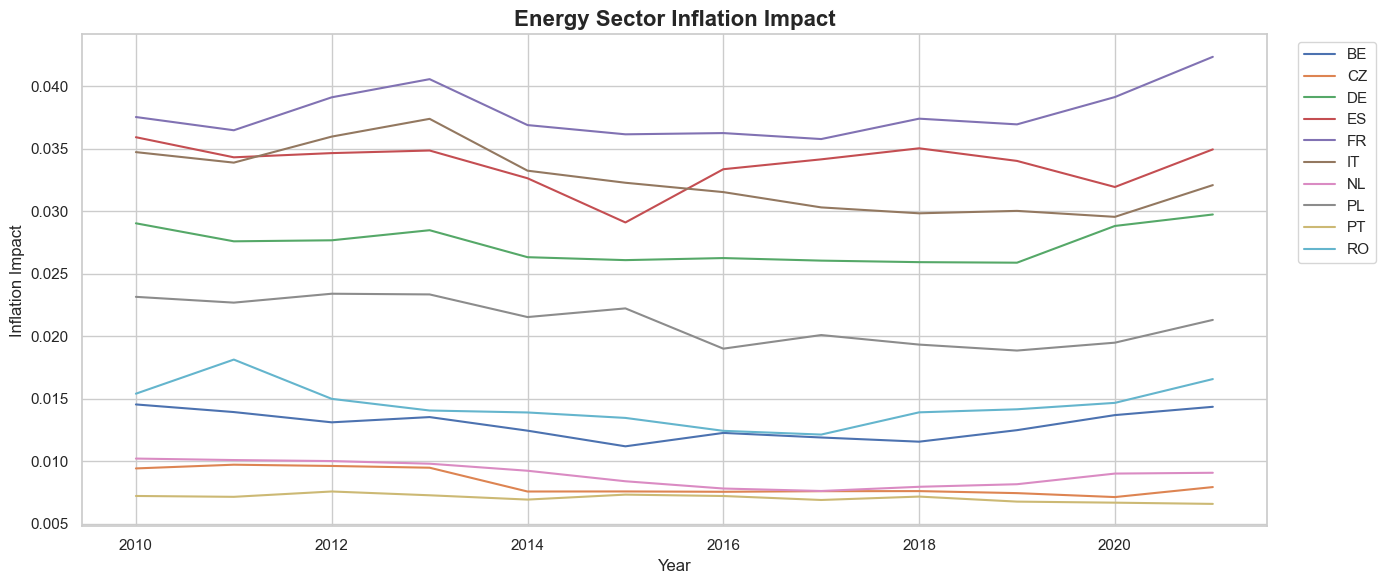

In [27]:
plot_sector_impact_over_time("D35", exclude_countries=["GB"], title="Energy Sector Inflation Impact")


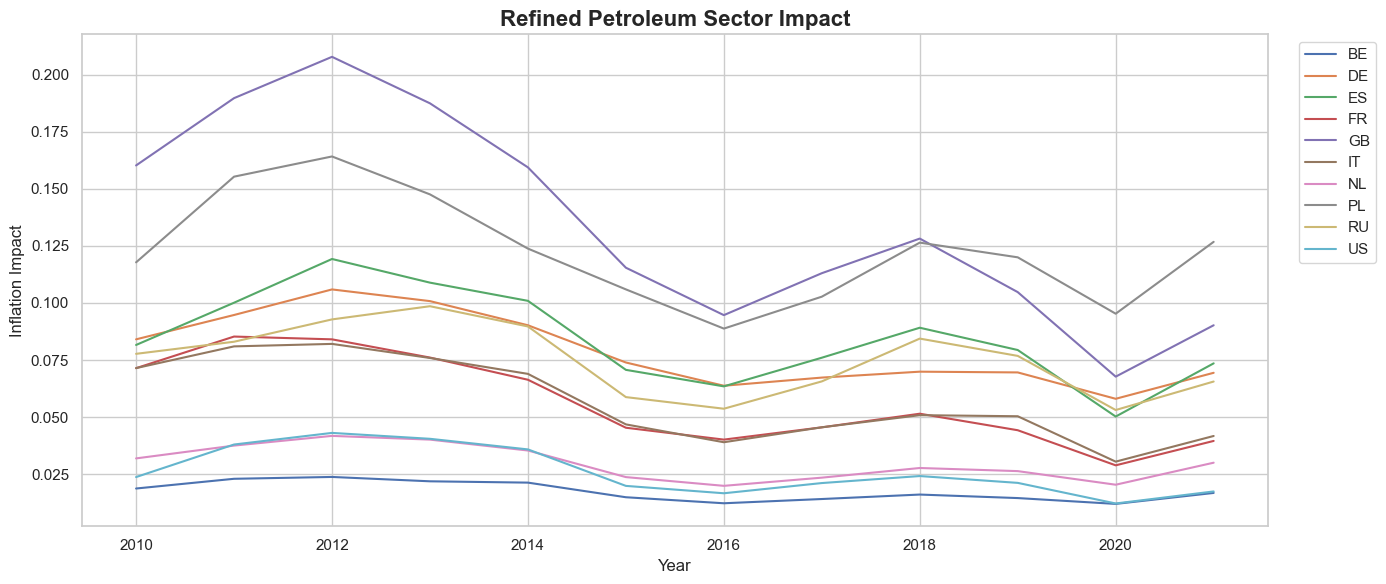

In [28]:
plot_sector_impact_over_time("C19", title="Refined Petroleum Sector Impact")


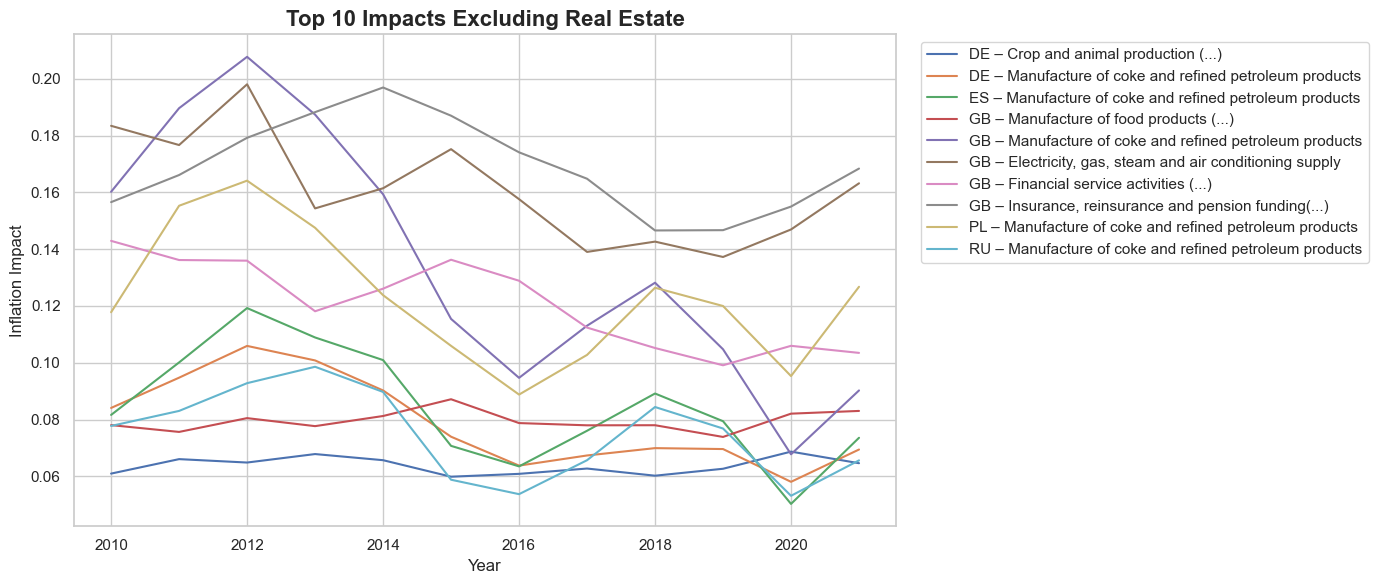

In [29]:
plot_sector_impact_over_time(
    sector_code=None,  # or loop over many
    exclude_sector="L68",
    title="Top 10 Impacts Excluding Real Estate"
)


In [30]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain  # for Louvain clustering
from pathlib import Path
from collections import defaultdict

def plot_country_io_clusters(A_path: Path, year: int, weight_threshold: float = 0.01):
    """
    Plot a country-level input-output network with clusters, excluding intra-country flows,
    and return a dictionary mapping cluster IDs to lists of countries.

    Parameters:
        A_path (Path): Path to A matrix
        year (int): Year
        weight_threshold (float): Minimum link weight to include

    Returns:
        dict: {cluster_id: [list of countries]}
    """
    # Load A matrix
    A = pd.read_csv(A_path, header=[0, 1], index_col=[0, 1])
    A.columns.names = ["Country", "Sector"]
    A.index.names = ["Country", "Sector"]

    # Aggregate to country-level flows
    A_country = A.groupby(level=0, axis=0).sum().groupby(level=0, axis=1).sum()

    # Build graph excluding intra-country flows
    G = nx.DiGraph()
    for source in A_country.index:
        for target in A_country.columns:
            if source != target:
                weight = A_country.loc[source, target]
                if weight > weight_threshold:
                    G.add_edge(source, target, weight=weight)

    # Run Louvain community detection
    undirected = G.to_undirected()
    partition = community_louvain.best_partition(undirected, weight="weight")

    # Group countries by cluster
    cluster_country_map = defaultdict(list)
    for country, cluster_id in partition.items():
        cluster_country_map[cluster_id].append(country)

    # Assign colors
    communities = list(set(partition.values()))
    color_map = {com: plt.cm.tab20(i % 20) for i, com in enumerate(communities)}
    node_colors = [color_map[partition[node]] for node in G.nodes()]

    # Draw graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=1.8, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
    edge_widths = [3 * (w / max(edge_weights)) for w in edge_weights]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color="gray", arrows=True)

    plt.title(f"Country-Level Input-Output Network ({year}) — Clustered", fontsize=18, fontweight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return dict(cluster_country_map)


C:\Users\danie\AppData\Local\Temp\ipykernel_4416\2322394200.py:27: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  A_country = A.groupby(level=0, axis=0).sum().groupby(level=0, axis=1).sum()
C:\Users\danie\AppData\Local\Temp\ipykernel_4416\2322394200.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  A_country = A.groupby(level=0, axis=0).sum().groupby(level=0, axis=1).sum()


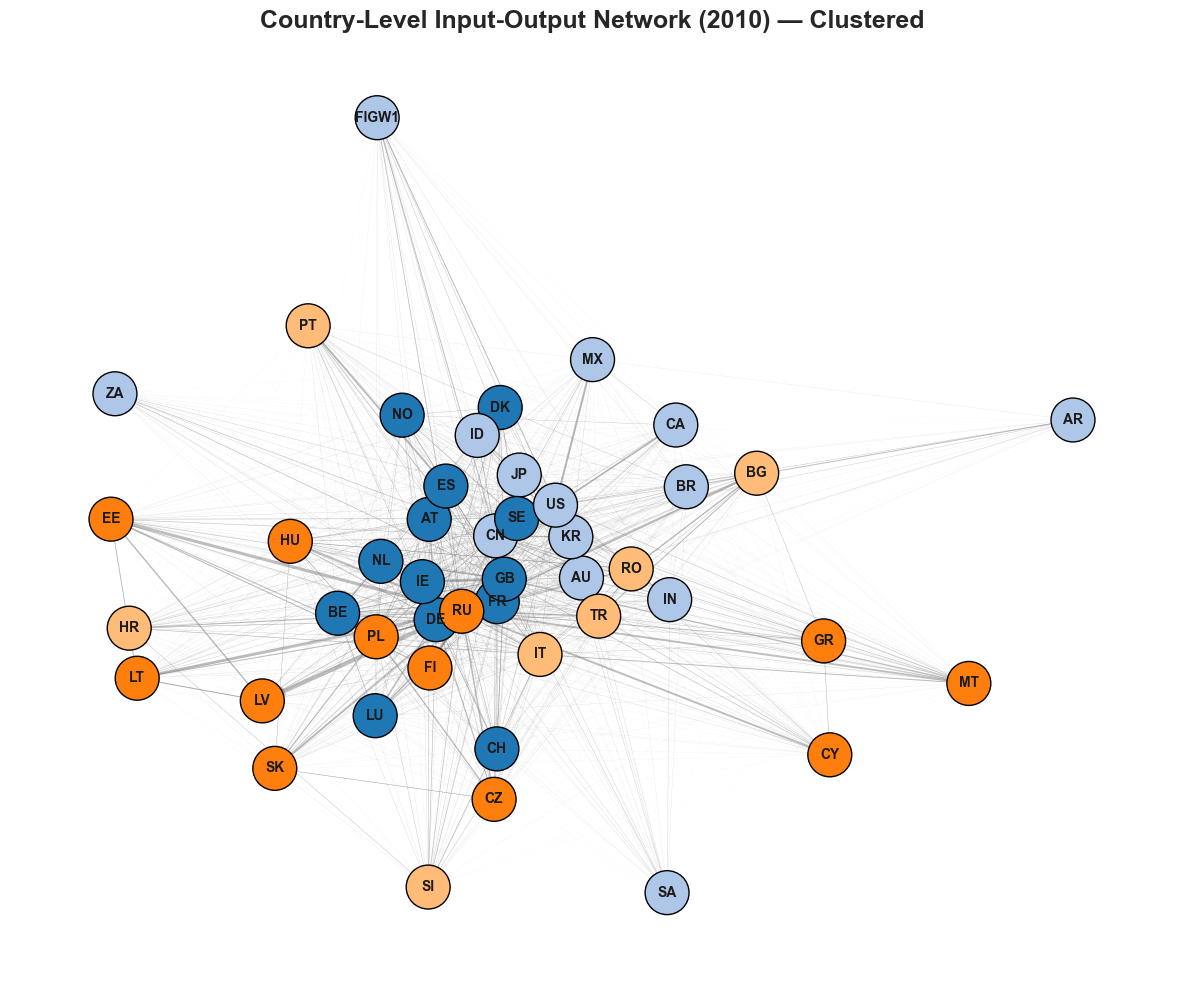

In [31]:
A_path = Path(SYSTEMIC_UNWEIGHTED_IMPACTS_DIR / "unweighted_shock_impacts_2010.csv")  # adapt to your actual path
cluster_map = plot_country_io_clusters(A_path=A_path, year=2010, weight_threshold=0.0)

C:\Users\danie\AppData\Local\Temp\ipykernel_4416\2322394200.py:27: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  A_country = A.groupby(level=0, axis=0).sum().groupby(level=0, axis=1).sum()
C:\Users\danie\AppData\Local\Temp\ipykernel_4416\2322394200.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  A_country = A.groupby(level=0, axis=0).sum().groupby(level=0, axis=1).sum()


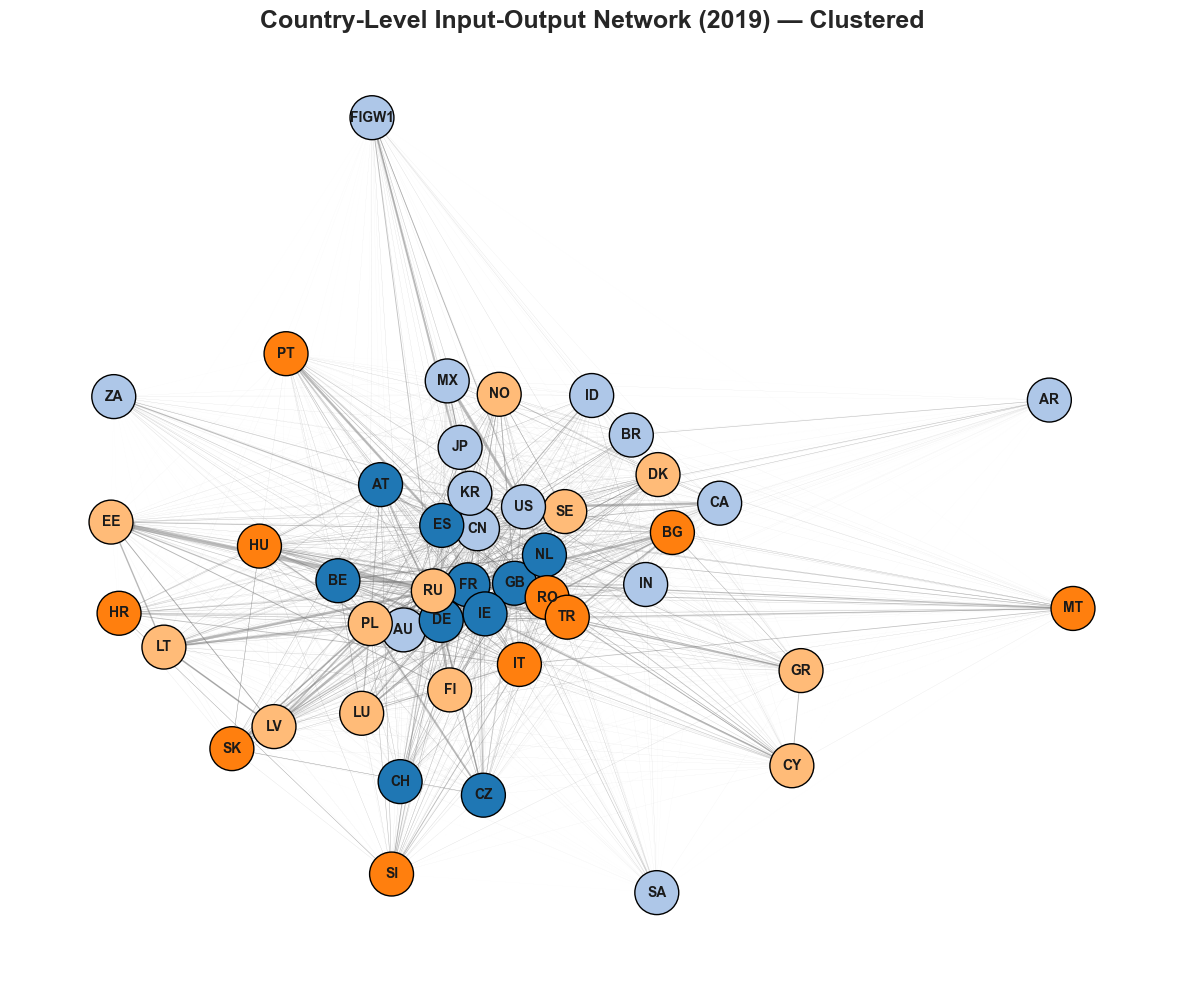

In [32]:
A_path = Path(SYSTEMIC_UNWEIGHTED_IMPACTS_DIR / "unweighted_shock_impacts_2019.csv")  # adapt to your actual path
cluster_map_2019 = plot_country_io_clusters(A_path=A_path, year=2019, weight_threshold=0.0)

In [33]:
import pandas as pd

# Step 1: Load results table
df = pd.read_csv("C:/Users/danie/Nextcloud/Coding/Masterthesis/part_systemically_significant_prices/outputs/weighted_impacts/weighted_impacts_cluster_2019.csv")

# Step 2: Clean and standardize column names
df.columns = df.columns.str.strip().str.replace(" ", "_")
df.rename(columns={"Region": "Region_to", "Total_Impact": "Impact"}, inplace=True)

# Step 3: Define the region assignment for each country
CLUSTER_REGION_MAP = {
    "AT": "core", "BE": "core", "CH": "core", "DE": "core", "ES": "core", "FR": "core", "GB": "core", "IE": "core", "NL": "core",
    "AR": "global", "AU": "global", "BR": "global", "CA": "global", "CN": "global", "FIGW1": "global", "ID": "global",
    "IN": "global", "JP": "global", "KR": "global", "MX": "global", "SA": "global", "US": "global", "ZA": "global",
    "BG": "SEP", "CY": "SEP", "GR": "SEP", "HR": "SEP", "IT": "SEP", "MT": "SEP", "PT": "SEP", "RO": "SEP", "SI": "SEP", "TR": "SEP",
    "CZ": "NEP", "DK": "NEP", "EE": "NEP", "FI": "NEP", "HU": "NEP", "LT": "NEP", "LU": "NEP", "LV": "NEP",
    "NO": "NEP", "PL": "NEP", "RU": "NEP", "SE": "NEP", "SK": "NEP"
}

# Step 4: Map Region_to from Country using the mapping
df["Region_from"] = df["Country"].map(CLUSTER_REGION_MAP)

# Step 5: Group by (Region_from, Region_to) and sum impacts
impact_summary = (
    df.groupby(["Region_from", "Region_to"])["Impact"]
    .sum()
    .reset_index()
    .pivot(index="Region_from", columns="Region_to", values="Impact")
    .fillna(0)
)

# Step 6: Round for readability
impact_summary = impact_summary.round(4)

# Step 7.1: Add column totals (sum over Region_from)
impact_summary.loc["Total"] = impact_summary.sum(axis=0)

# Step 7: Output or return
print(impact_summary)


Region_to        NEP      SEP    core  global
Region_from                                  
NEP           9.5082   0.6011  0.4961  0.1448
SEP           0.2958   8.5933  0.3009  0.0855
core          0.7719   0.7707  6.2808  0.2764
global        0.5958   0.4787  0.5632  4.3217
Total        11.1717  10.4438  7.6410  4.8284


In [34]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain  # for Louvain clustering
from pathlib import Path

def plot_sector_io_clusters(A_path: Path, year: int, weight_threshold: float = 0.01):
    """
    Plot a sector-level input-output network with Louvain clusters, excluding self-loops.

    Parameters:
        A_path (Path): Path to A matrix (sector x sector)
        year (int): Year for title
        weight_threshold (float): Minimum link weight to include
    """
    # Load A matrix
    A = pd.read_csv(A_path, header=[0, 1], index_col=[0, 1])
    A.columns.names = ["Country", "Sector"]
    A.index.names = ["Country", "Sector"]

    # Aggregate to sector-level flows (collapsing countries)
    A_sector = A.groupby(level="Sector", axis=1).sum().groupby(level="Sector", axis=0).sum()

    # Build directed graph, excluding self-loops
    G = nx.DiGraph()
    for source in A_sector.index:
        for target in A_sector.columns:
            if source != target:
                weight = A_sector.loc[source, target]
                if weight > weight_threshold:
                    G.add_edge(source, target, weight=weight)

    # Louvain clustering
    undirected = G.to_undirected()
    partition = community_louvain.best_partition(undirected, weight="weight")

    # Assign colors by community
    communities = sorted(set(partition.values()))
    color_map = {com: plt.cm.tab20(i % 20) for i, com in enumerate(communities)}
    node_colors = [color_map[partition[node]] for node in G.nodes()]

    # Draw network
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=1.5, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
    edge_widths = [3 * (w / max(edge_weights)) for w in edge_weights]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4, edge_color="gray", arrows=True)

    plt.title(f"Sector-Level Input-Output Network ({year}) — Louvain Clustering", fontsize=16, fontweight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


C:\Users\danie\AppData\Local\Temp\ipykernel_4416\3557431053.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  A_sector = A.groupby(level="Sector", axis=1).sum().groupby(level="Sector", axis=0).sum()
C:\Users\danie\AppData\Local\Temp\ipykernel_4416\3557431053.py:22: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  A_sector = A.groupby(level="Sector", axis=1).sum().groupby(level="Sector", axis=0).sum()


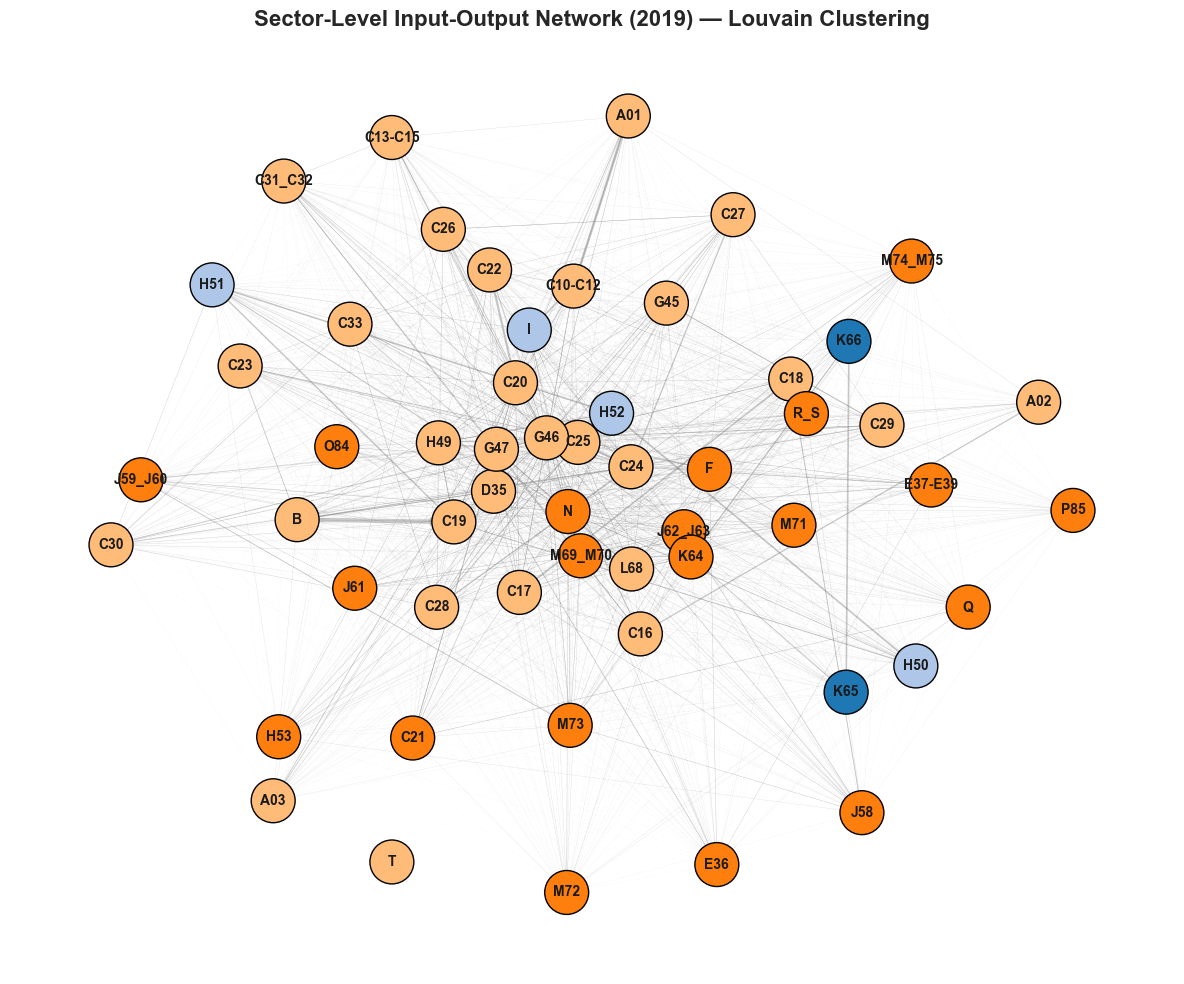

In [35]:
plot_sector_io_clusters(A_path=Path(SYSTEMIC_A_MATRIX_DIR/"A_2019.csv"), year=2019)
